In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1006.38it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1038.26it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 989.79it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 672.90it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 2), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 10
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  61.9579%, Val Regret:  66.5088%


Epoch    0, Loss:   0.5669:  10%|█████▌                                                 | 1/10 [00:05<00:34,  3.79s/it]

Epoch   1, Train Regret:  33.7147%, Val Regret:  38.3390%


Epoch    1, Loss:   0.4282:  20%|███████████                                            | 2/10 [00:08<00:25,  3.14s/it]

Epoch   2, Train Regret:  16.8399%, Val Regret:  18.2600%


Epoch    2, Loss:   0.1096:  30%|████████████████▌                                      | 3/10 [00:10<00:20,  2.97s/it]

Epoch   3, Train Regret:  10.6229%, Val Regret:  11.0463%


Epoch    3, Loss:   0.1251:  40%|██████████████████████                                 | 4/10 [00:13<00:17,  2.90s/it]

Epoch   4, Train Regret:   8.5983%, Val Regret:   8.0452%


Epoch    4, Loss:   0.0531:  50%|███████████████████████████▌                           | 5/10 [00:16<00:14,  2.86s/it]

Epoch   5, Train Regret:   7.6684%, Val Regret:   7.9813%


Epoch    5, Loss:   0.1983:  60%|█████████████████████████████████                      | 6/10 [00:19<00:11,  2.83s/it]

Epoch   6, Train Regret:   7.7612%, Val Regret:   7.8837%


Epoch    6, Loss:   0.1061:  70%|██████████████████████████████████████▌                | 7/10 [00:22<00:08,  2.84s/it]

Epoch   7, Train Regret:   7.9067%, Val Regret:   7.8011%


Epoch    7, Loss:   0.0589:  80%|████████████████████████████████████████████           | 8/10 [00:25<00:05,  2.86s/it]

Epoch   8, Train Regret:   7.7140%, Val Regret:   8.0460%


Epoch    8, Loss:   0.3751:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:27<00:02,  2.90s/it]

Epoch   9, Train Regret:   7.7533%, Val Regret:   7.7828%


Epoch    9, Loss:   0.1208: 100%|██████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.90s/it]


Epoch   9, Train Regret:   7.8694%, Val Regret:   8.2066%
Training Elapsed Time: 1.96 Sec

Evaluation:
Test Regret: 8.4272%
Test Elapsed Time: 1.46 Sec


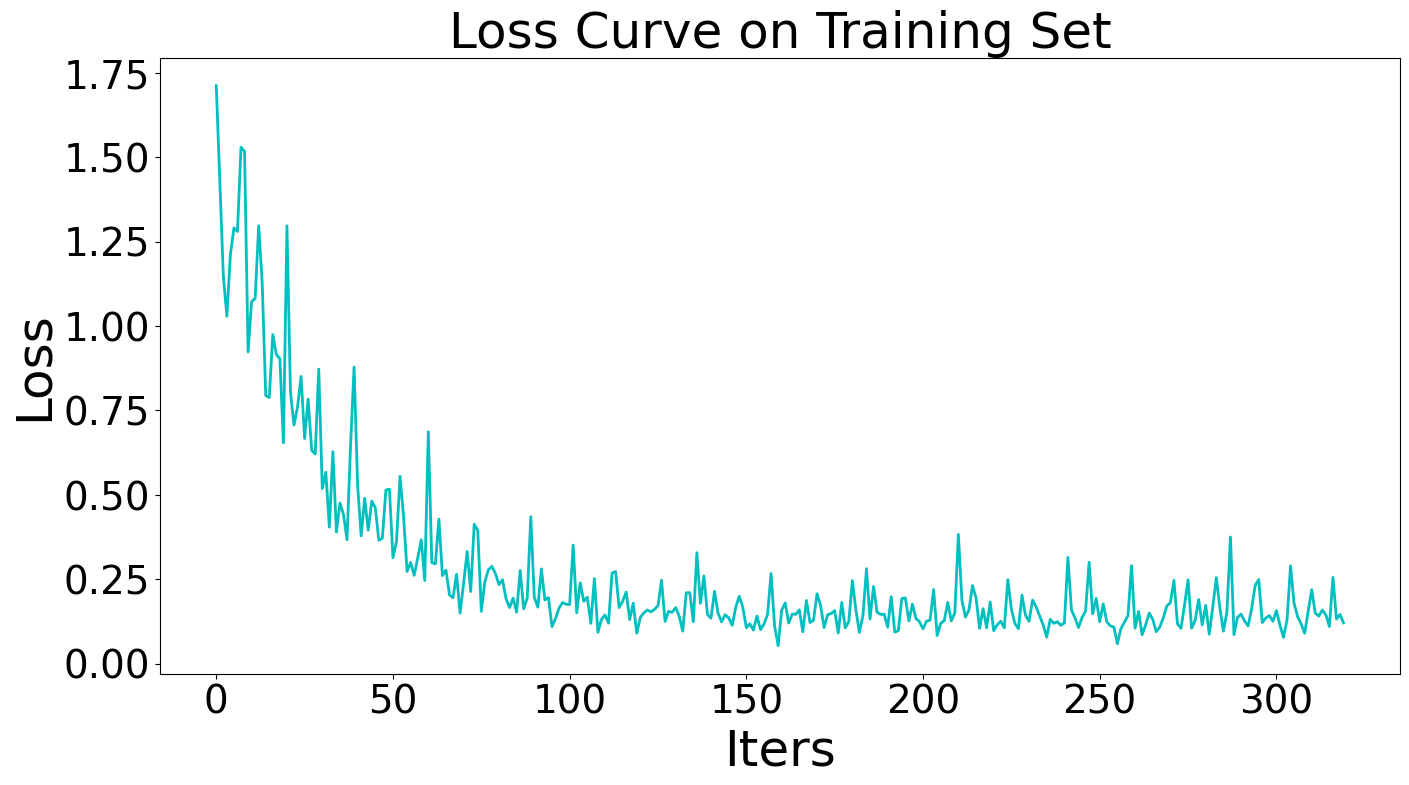

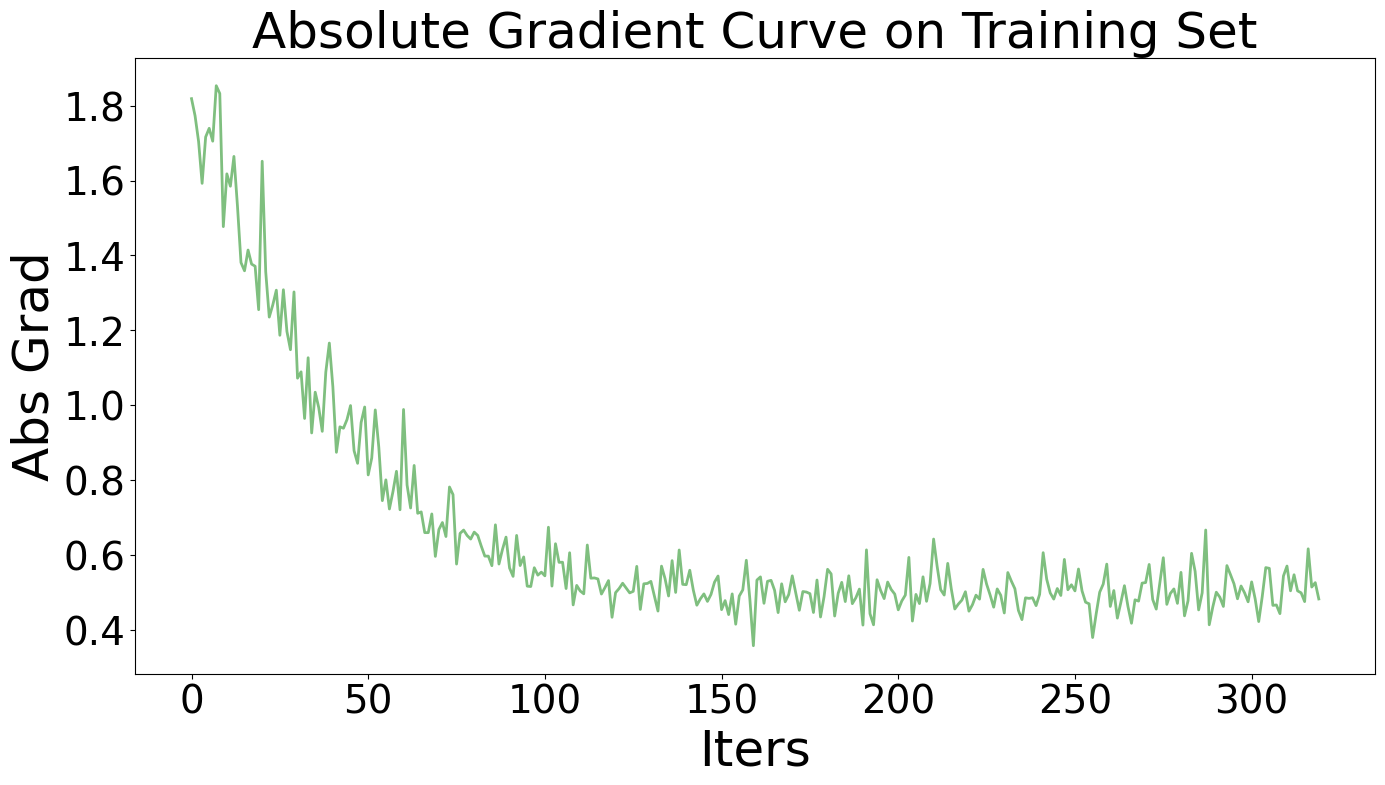

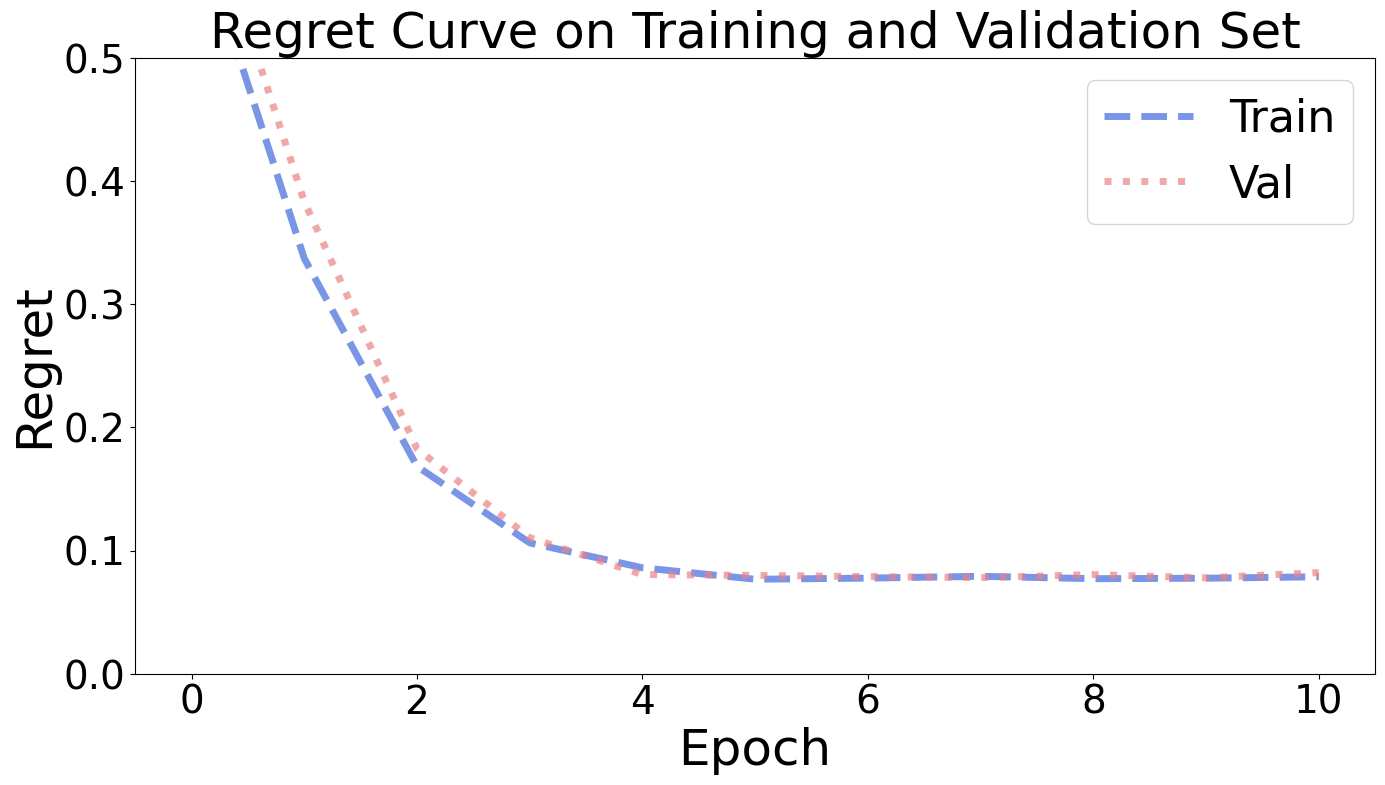

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 06 01:12:09 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  60.5412%, Val Regret:  64.2153%


Epoch    0, Loss:  -0.9838:  10%|█████▌                                                 | 1/10 [00:10<01:19,  8.89s/it]

Epoch   1, Train Regret:   7.5013%, Val Regret:   6.6730%


Epoch    1, Loss:  -0.9763:  20%|███████████                                            | 2/10 [00:15<00:52,  6.51s/it]

Epoch   2, Train Regret:   7.6915%, Val Regret:   7.6961%


Epoch    2, Loss:  -0.9900:  30%|████████████████▌                                      | 3/10 [00:19<00:39,  5.63s/it]

Epoch   3, Train Regret:   7.2724%, Val Regret:   8.5289%


Epoch    3, Loss:  -0.9785:  40%|██████████████████████                                 | 4/10 [00:24<00:36,  6.11s/it]


Epoch   4, Train Regret:   7.3748%, Val Regret:   7.5101%

Early Stop!
Training Elapsed Time: 12.39 Sec

Evaluation:
Test Regret: 8.5492%
Test Elapsed Time: 1.34 Sec


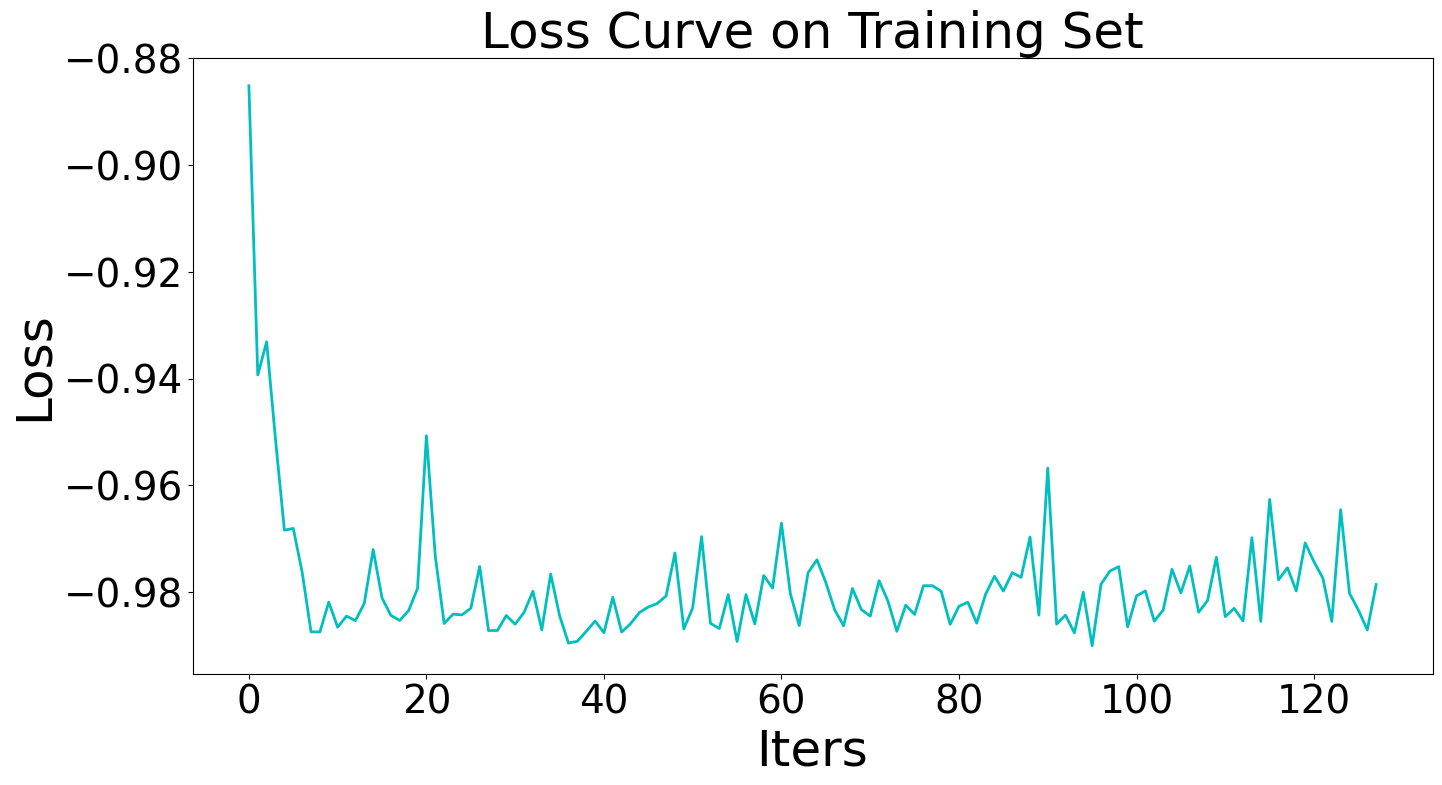

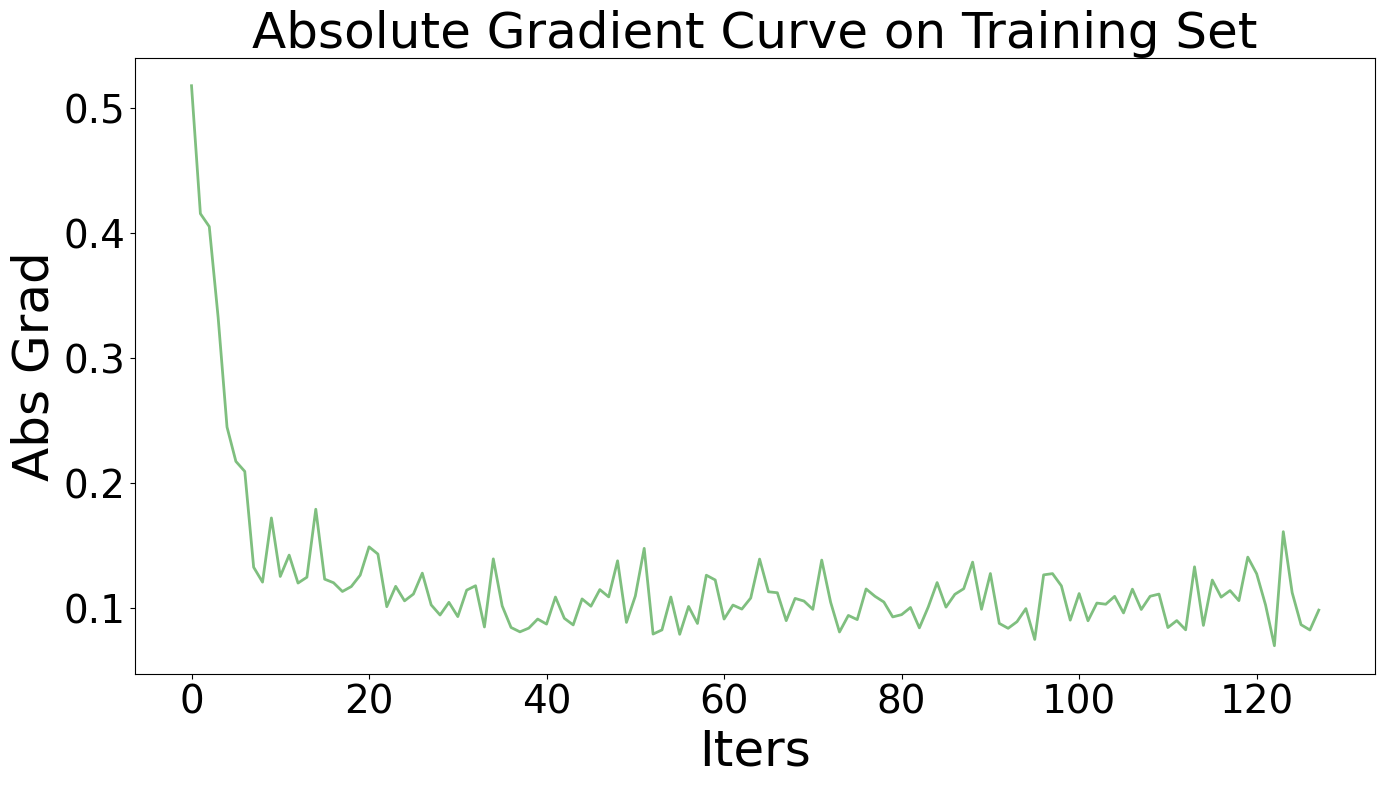

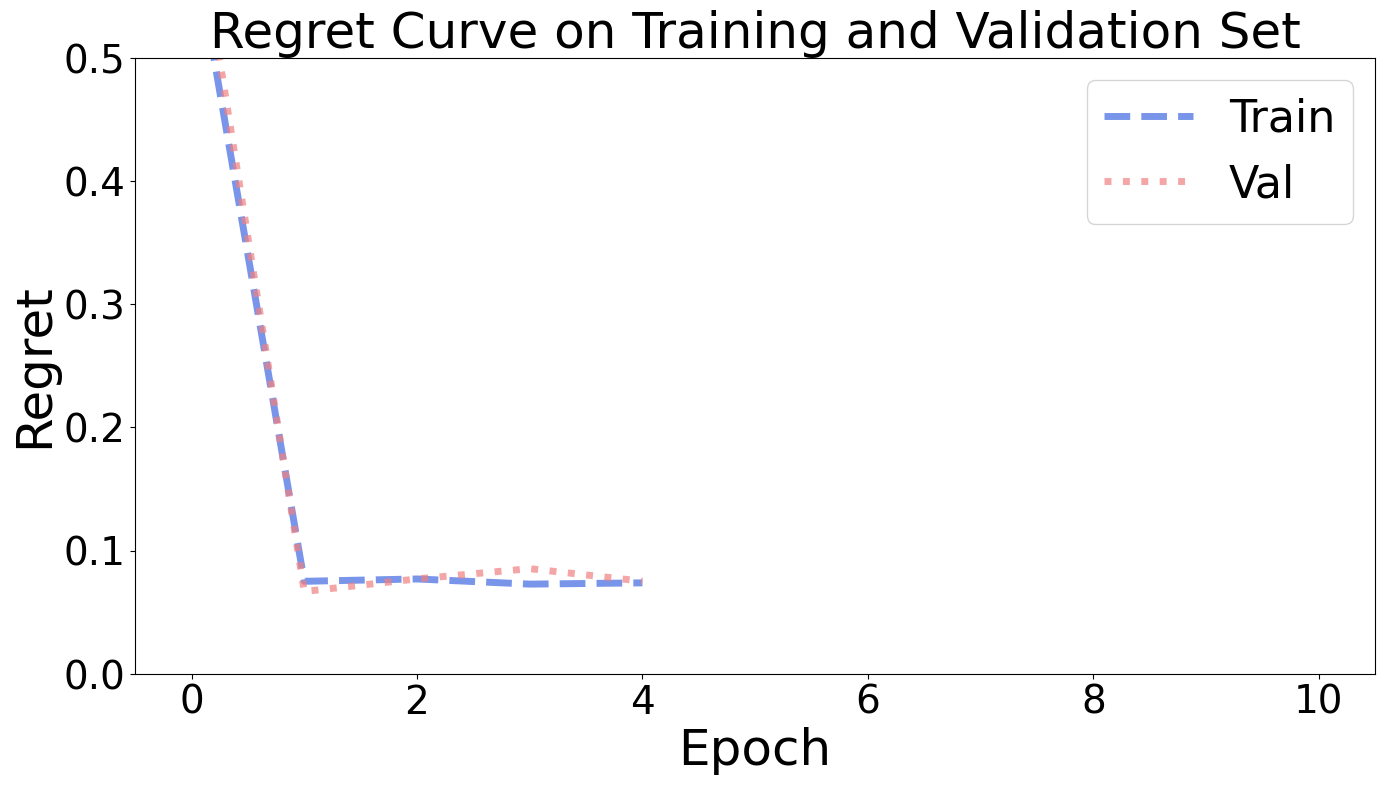

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [22]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  71.2160%, Val Regret:  73.2458%


Epoch    0, Loss:  -0.9989:  10%|█████▌                                                 | 1/10 [00:04<00:27,  3.07s/it]

Epoch   1, Train Regret:  10.2044%, Val Regret:   9.2434%


Epoch    1, Loss:  -0.9991:  20%|███████████                                            | 2/10 [00:07<00:24,  3.06s/it]

Epoch   2, Train Regret:   8.8780%, Val Regret:  10.0802%


Epoch    2, Loss:  -1.0000:  30%|████████████████▌                                      | 3/10 [00:10<00:21,  3.06s/it]

Epoch   3, Train Regret:   9.5535%, Val Regret:  11.3339%


Epoch    3, Loss:  -0.9999:  40%|██████████████████████                                 | 4/10 [00:13<00:20,  3.47s/it]


Epoch   4, Train Regret:   9.6685%, Val Regret:  14.6429%

Early Stop!
Training Elapsed Time: 1.55 Sec

Evaluation:
Test Regret: 11.8804%
Test Elapsed Time: 1.55 Sec


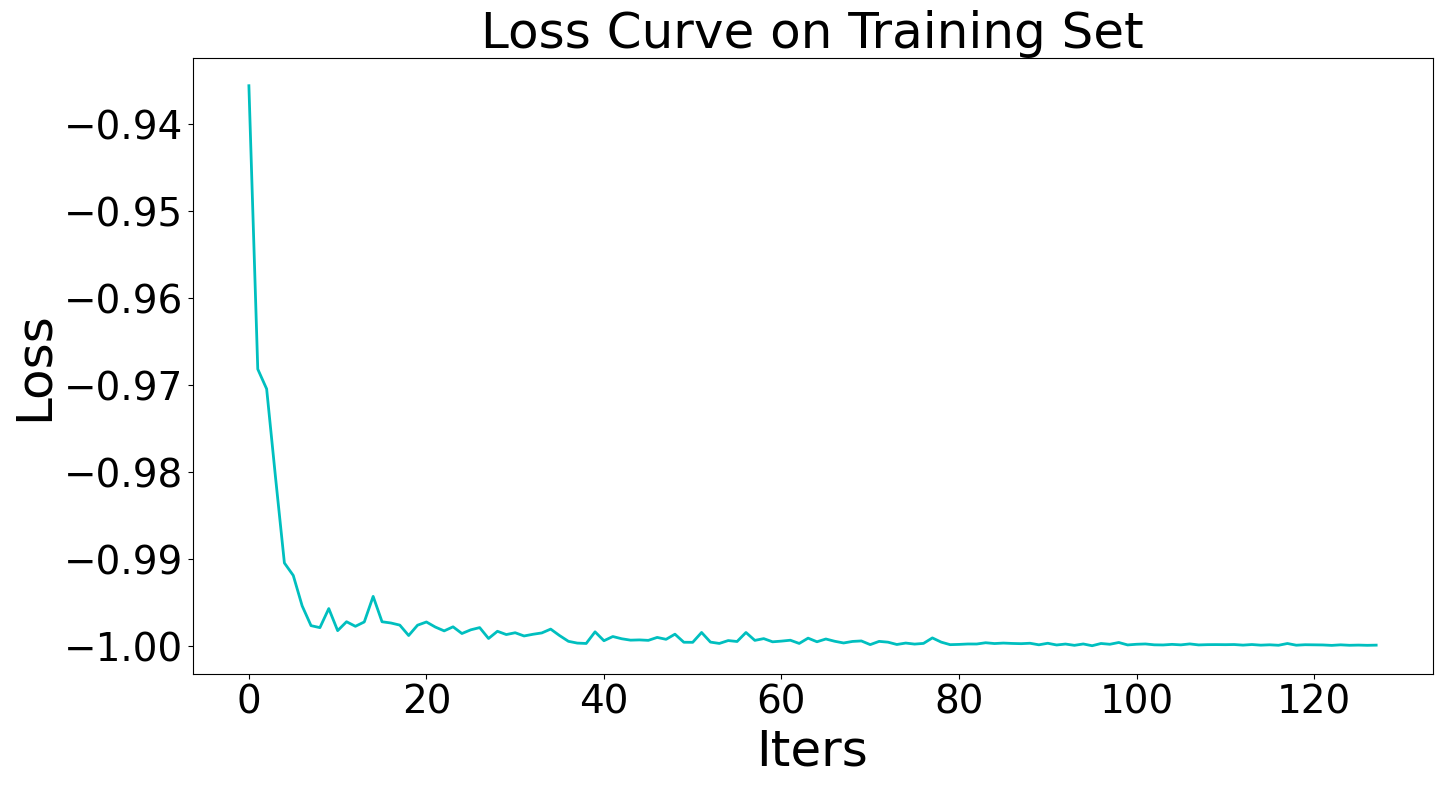

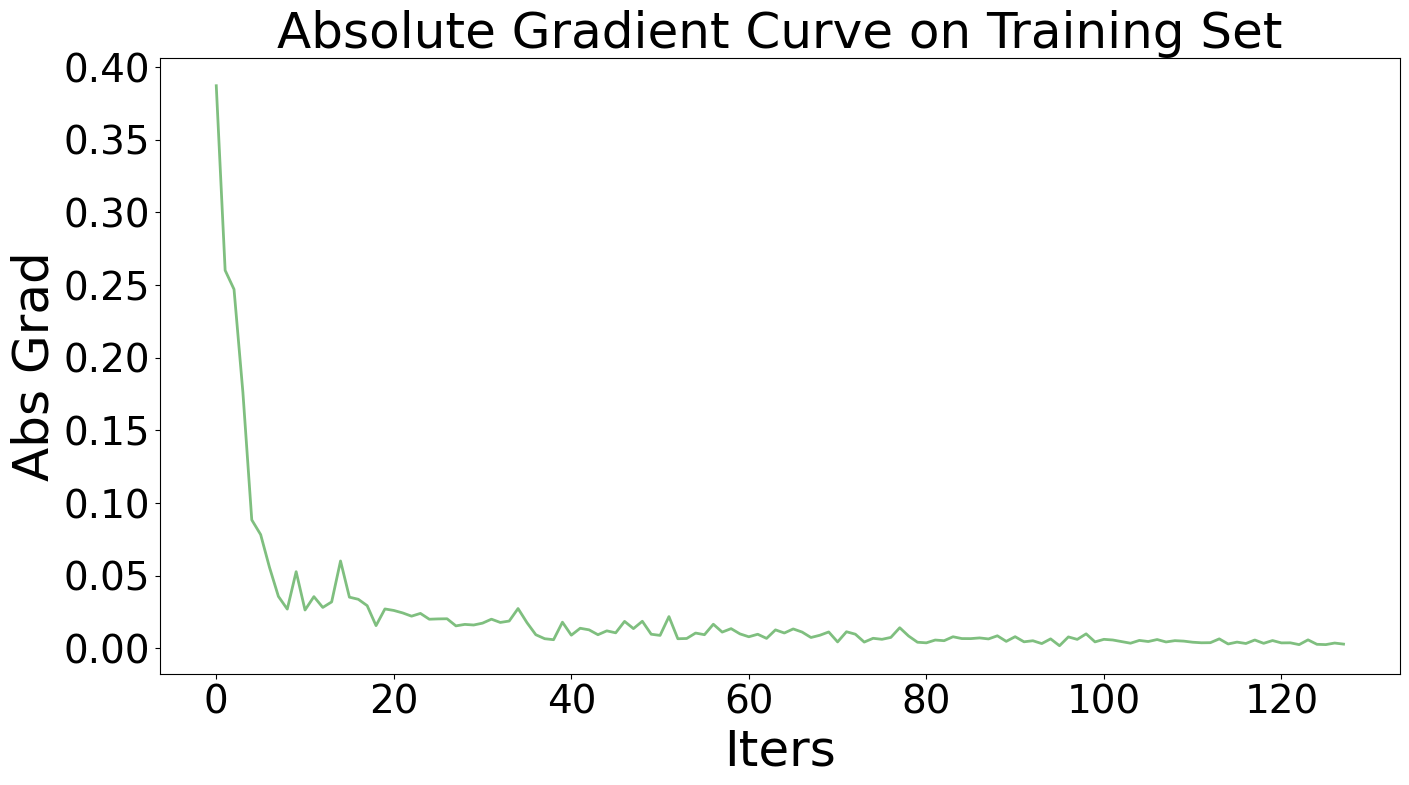

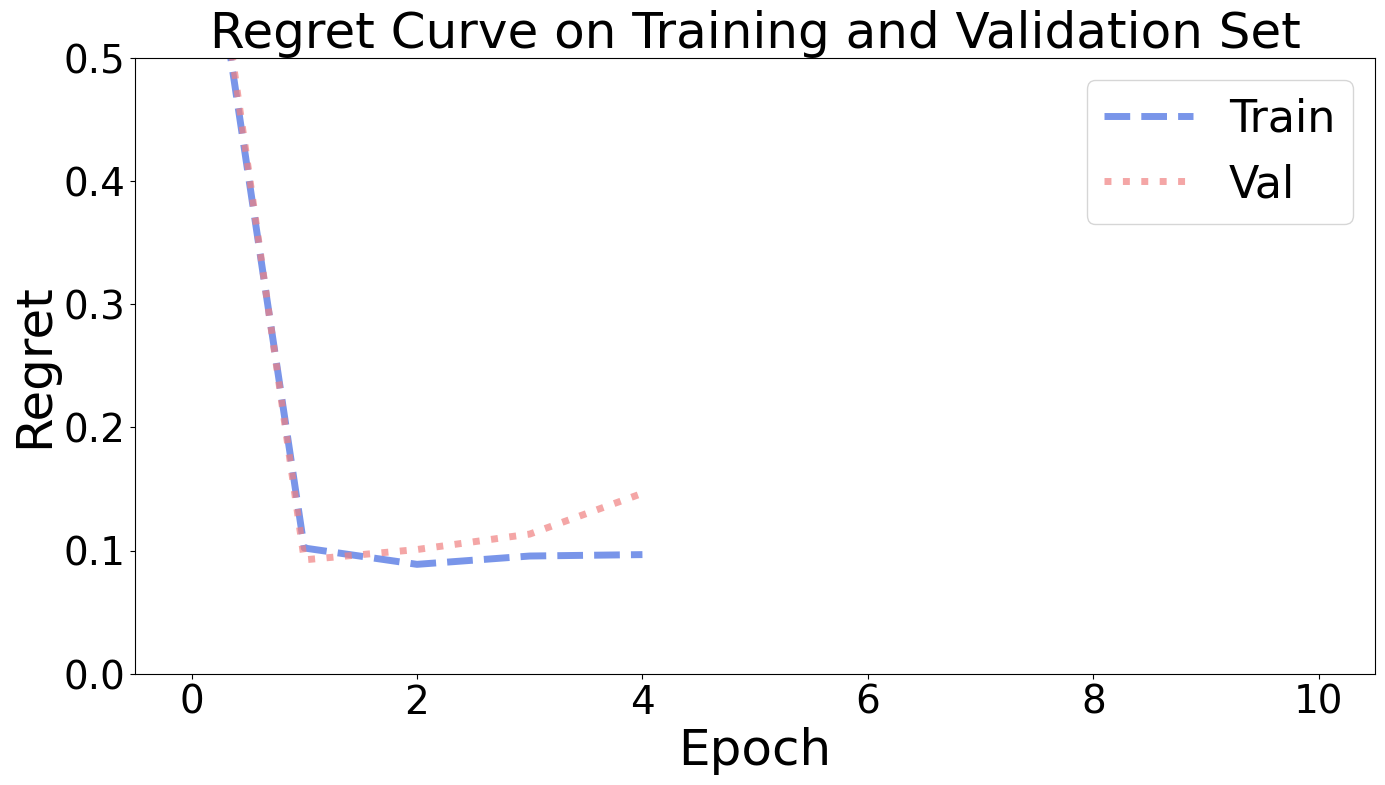

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [26]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  71.2160%, Val Regret:  73.2458%


Epoch    0, Loss:  -0.9982:  10%|█████▌                                                 | 1/10 [00:04<00:28,  3.17s/it]

Epoch   1, Train Regret:  22.5992%, Val Regret:  24.6335%


Epoch    1, Loss:  -0.9987:  20%|███████████                                            | 2/10 [00:07<00:24,  3.11s/it]

Epoch   2, Train Regret:  10.4777%, Val Regret:  10.3376%


Epoch    2, Loss:  -0.9995:  30%|████████████████▌                                      | 3/10 [00:11<00:21,  3.11s/it]

Epoch   3, Train Regret:   8.8001%, Val Regret:   9.0854%


Epoch    3, Loss:  -0.9994:  40%|██████████████████████                                 | 4/10 [00:14<00:18,  3.09s/it]

Epoch   4, Train Regret:   8.7180%, Val Regret:   8.4274%


Epoch    4, Loss:  -0.9979:  50%|███████████████████████████▌                           | 5/10 [00:17<00:15,  3.09s/it]

Epoch   5, Train Regret:   8.5303%, Val Regret:   7.9281%


Epoch    5, Loss:  -0.9999:  60%|█████████████████████████████████                      | 6/10 [00:20<00:12,  3.10s/it]

Epoch   6, Train Regret:   8.3687%, Val Regret:   7.8287%


Epoch    6, Loss:  -0.9996:  70%|██████████████████████████████████████▌                | 7/10 [00:23<00:09,  3.10s/it]

Epoch   7, Train Regret:   8.3423%, Val Regret:   8.5667%


Epoch    7, Loss:  -0.9992:  80%|████████████████████████████████████████████           | 8/10 [00:26<00:06,  3.08s/it]

Epoch   8, Train Regret:   8.0919%, Val Regret:   8.1099%


Epoch    8, Loss:  -0.9993:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:29<00:03,  3.07s/it]

Epoch   9, Train Regret:   7.9478%, Val Regret:   7.4361%


Epoch    9, Loss:  -0.9997: 100%|██████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.10s/it]


Epoch   9, Train Regret:   8.2007%, Val Regret:   8.4670%
Training Elapsed Time: 4.02 Sec

Evaluation:
Test Regret: 8.3088%
Test Elapsed Time: 1.56 Sec


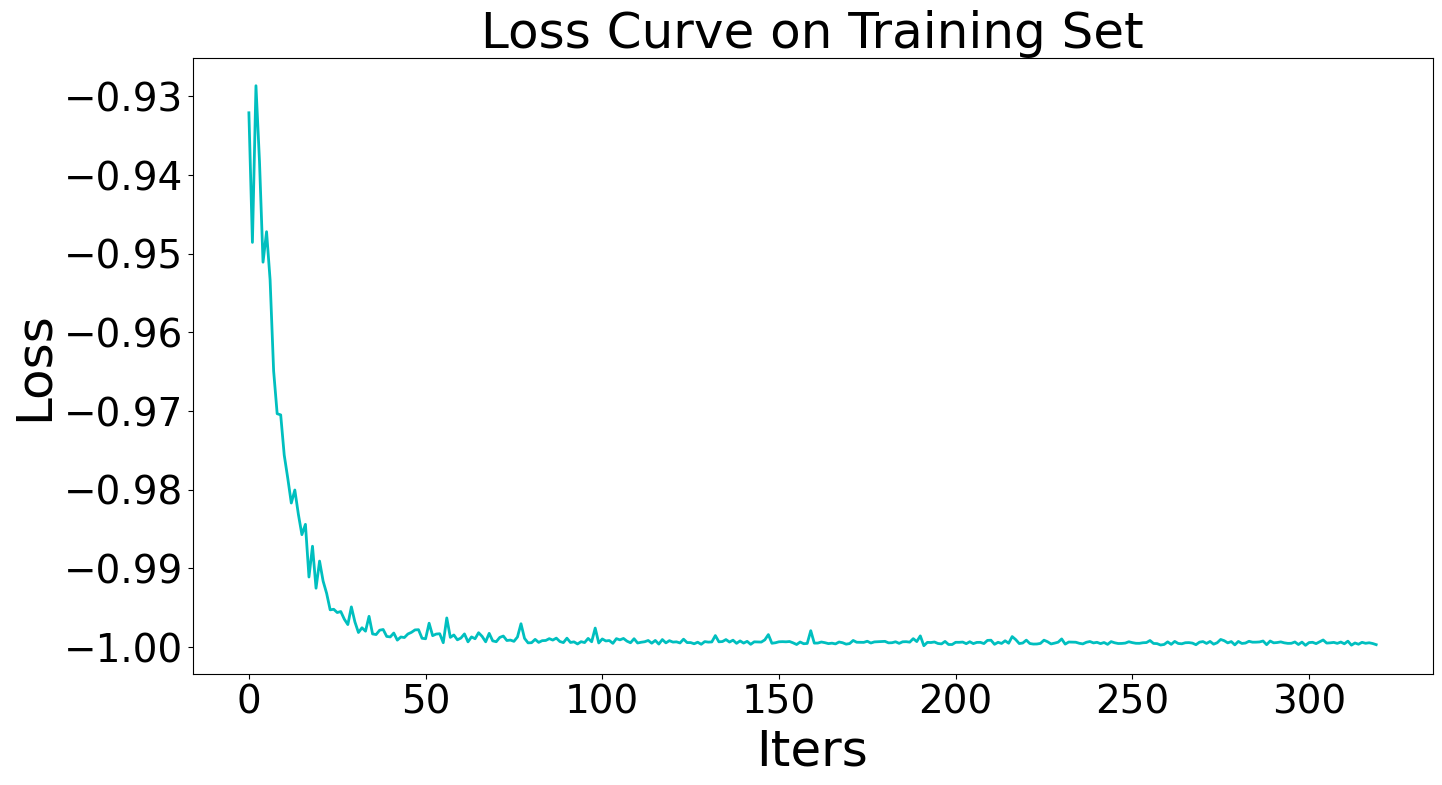

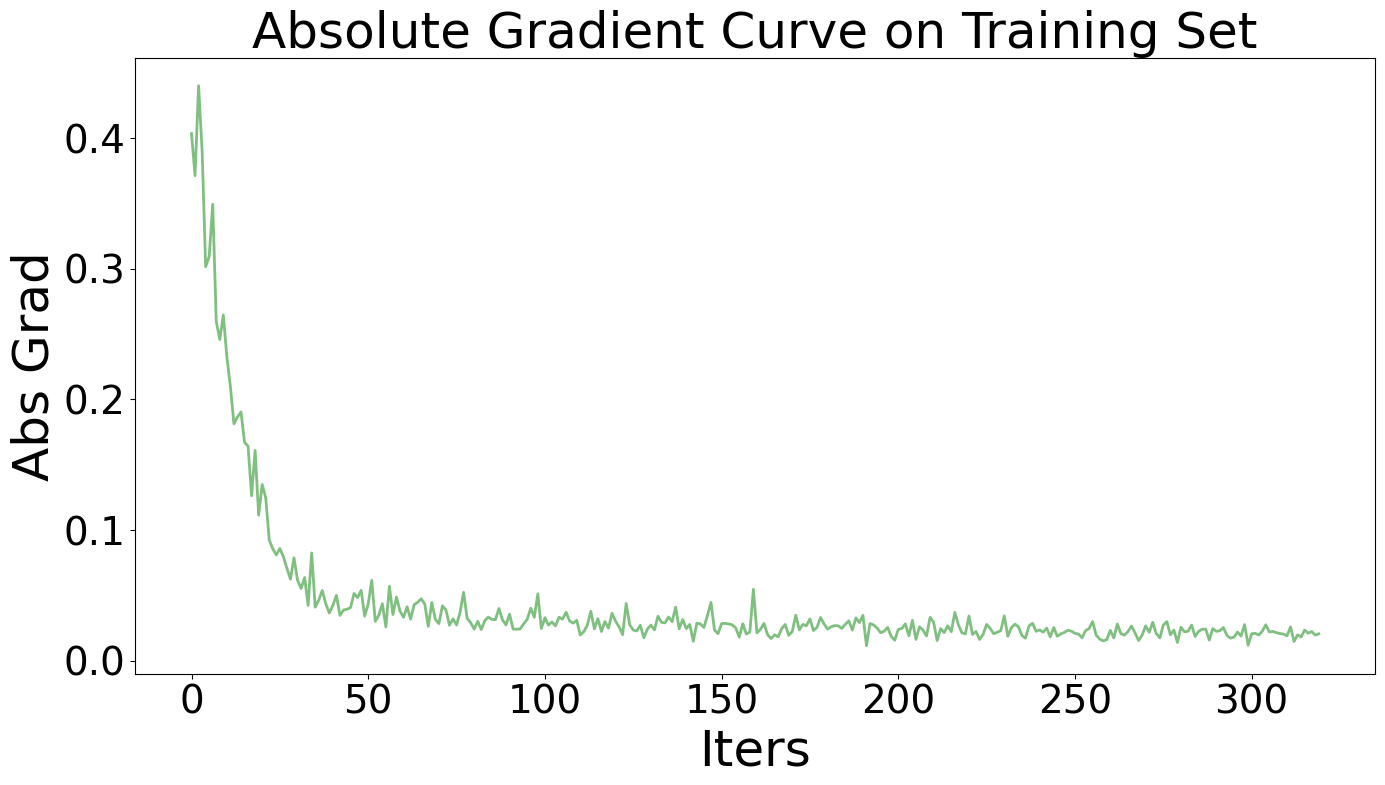

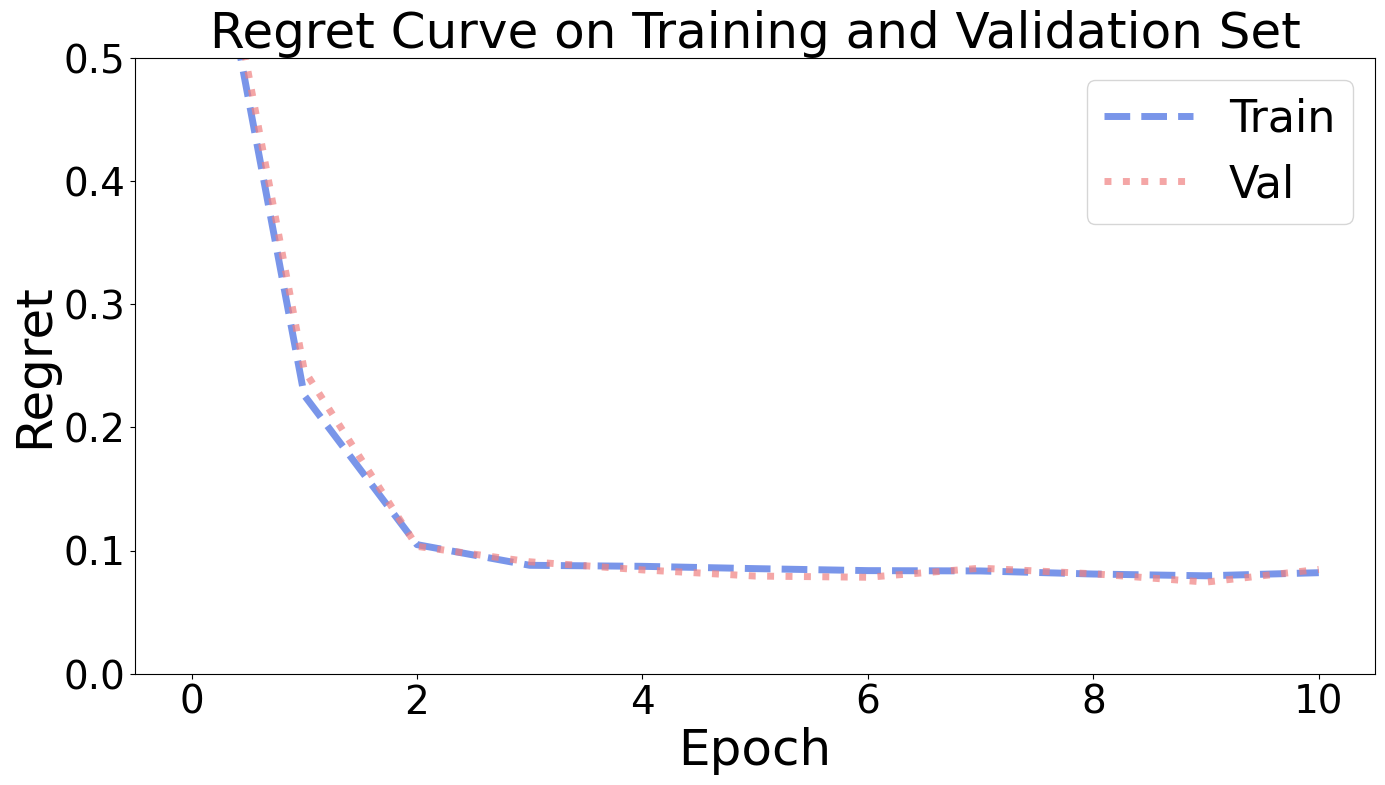

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner & Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="nnls", solve_ratio=0.1, processes=1)

Num of cores: 1


In [30]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  60.5412%, Val Regret:  64.2153%


Epoch    0, Loss:  -0.9999:  10%|█████▌                                                 | 1/10 [00:04<00:24,  2.76s/it]

Epoch   1, Train Regret:  36.3085%, Val Regret:  38.5674%


Epoch    1, Loss:  -0.9999:  20%|███████████                                            | 2/10 [00:07<00:22,  2.83s/it]

Epoch   2, Train Regret:  16.8260%, Val Regret:  17.4994%


Epoch    2, Loss:  -0.9999:  30%|████████████████▌                                      | 3/10 [00:10<00:19,  2.82s/it]

Epoch   3, Train Regret:  10.8240%, Val Regret:  11.1802%


Epoch    3, Loss:  -0.9999:  40%|██████████████████████                                 | 4/10 [00:12<00:16,  2.78s/it]

Epoch   4, Train Regret:   9.7092%, Val Regret:  10.9078%


Epoch    4, Loss:  -0.9999:  50%|███████████████████████████▌                           | 5/10 [00:15<00:13,  2.79s/it]

Epoch   5, Train Regret:   9.9494%, Val Regret:  11.3016%


Epoch    5, Loss:  -0.9999:  60%|█████████████████████████████████                      | 6/10 [00:18<00:11,  2.78s/it]

Epoch   6, Train Regret:   8.8068%, Val Regret:  10.3581%


Epoch    6, Loss:  -0.9999:  70%|██████████████████████████████████████▌                | 7/10 [00:21<00:08,  2.78s/it]

Epoch   7, Train Regret:   8.5761%, Val Regret:   9.2238%


Epoch    7, Loss:  -0.9999:  80%|████████████████████████████████████████████           | 8/10 [00:23<00:05,  2.76s/it]

Epoch   8, Train Regret:   8.4999%, Val Regret:   8.7984%


Epoch    8, Loss:  -0.9999:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:26<00:02,  2.77s/it]

Epoch   9, Train Regret:   8.3399%, Val Regret:   9.9145%


Epoch    9, Loss:  -0.9999: 100%|██████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.78s/it]


Epoch   9, Train Regret:   8.0287%, Val Regret:   8.0852%
Training Elapsed Time: 1.37 Sec

Evaluation:
Test Regret: 8.2781%
Test Elapsed Time: 1.62 Sec


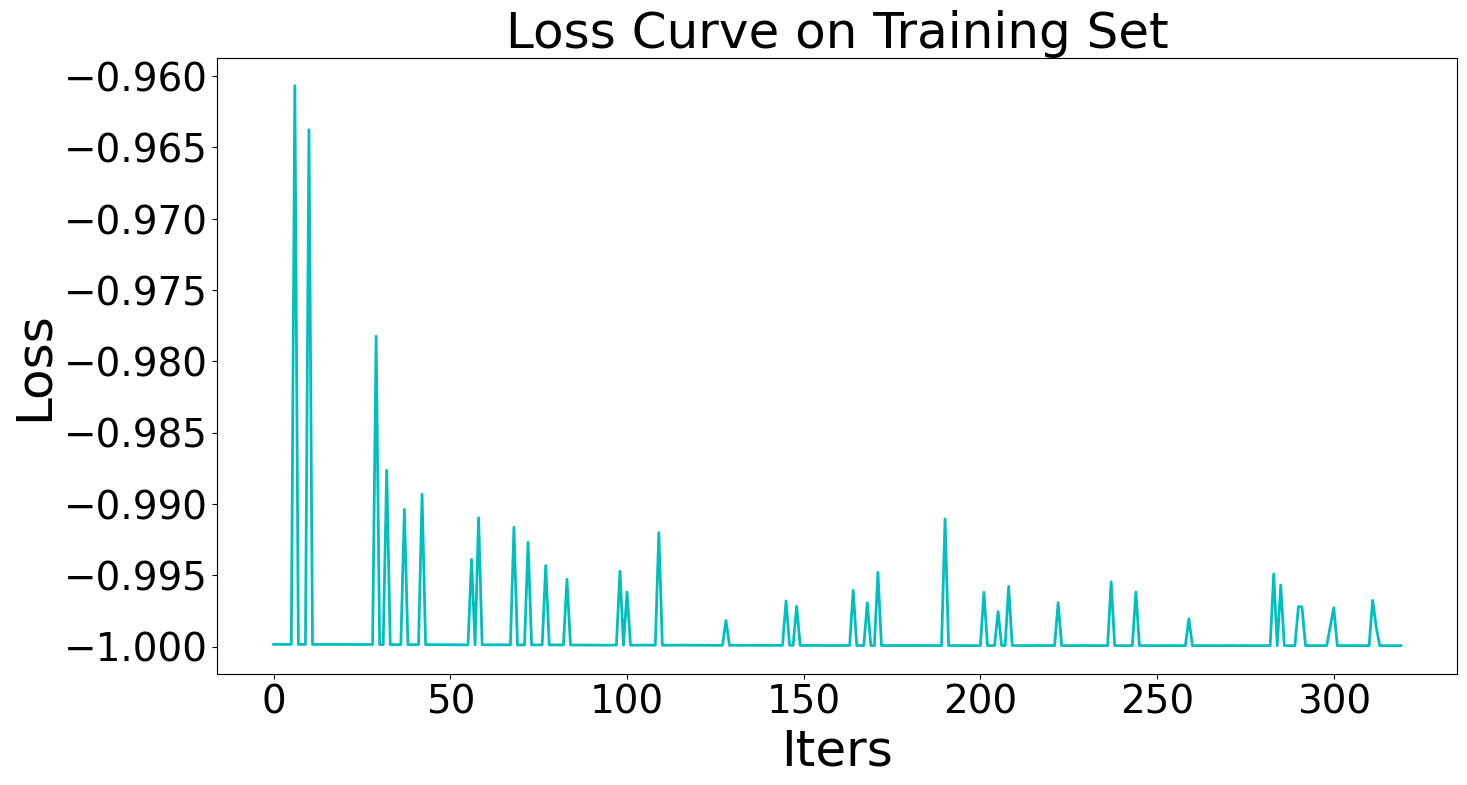

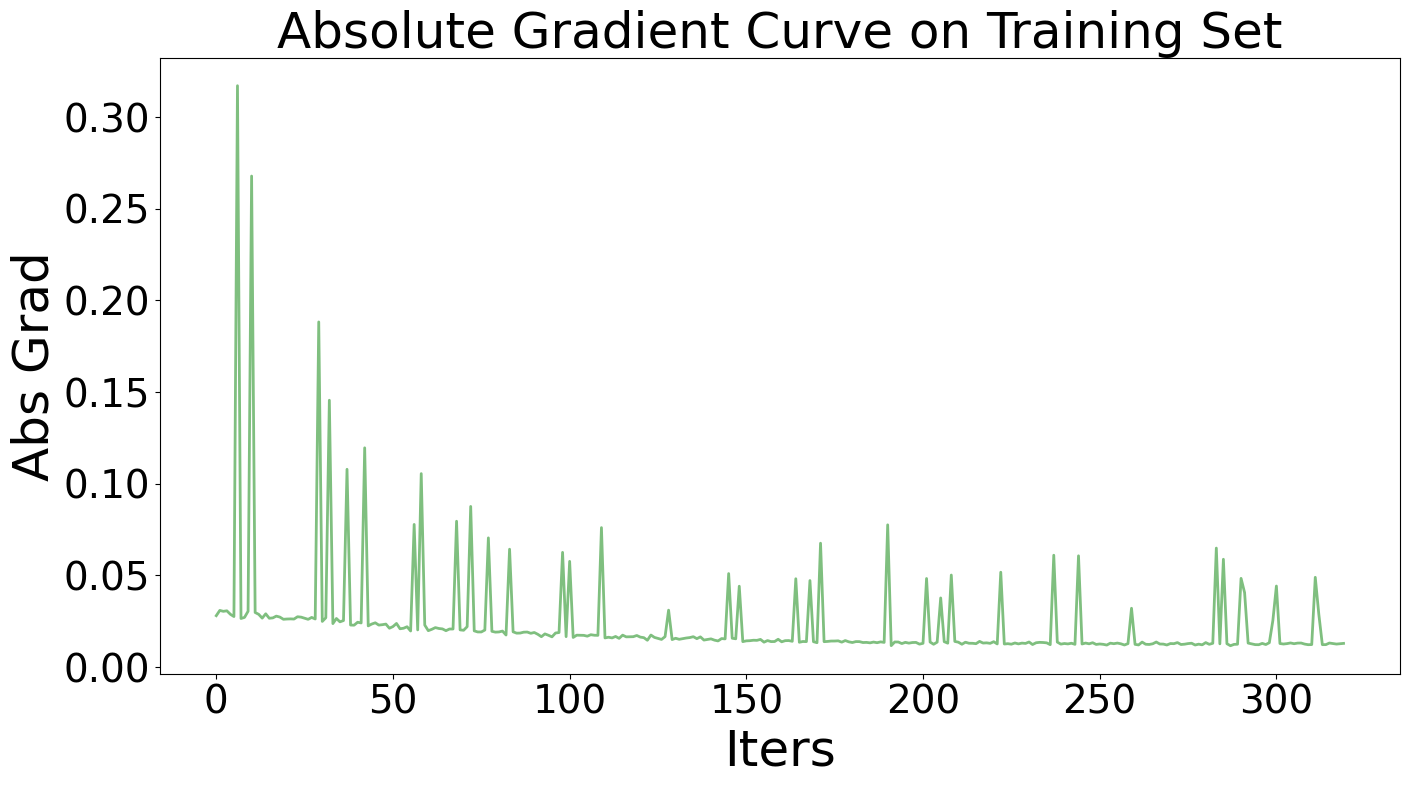

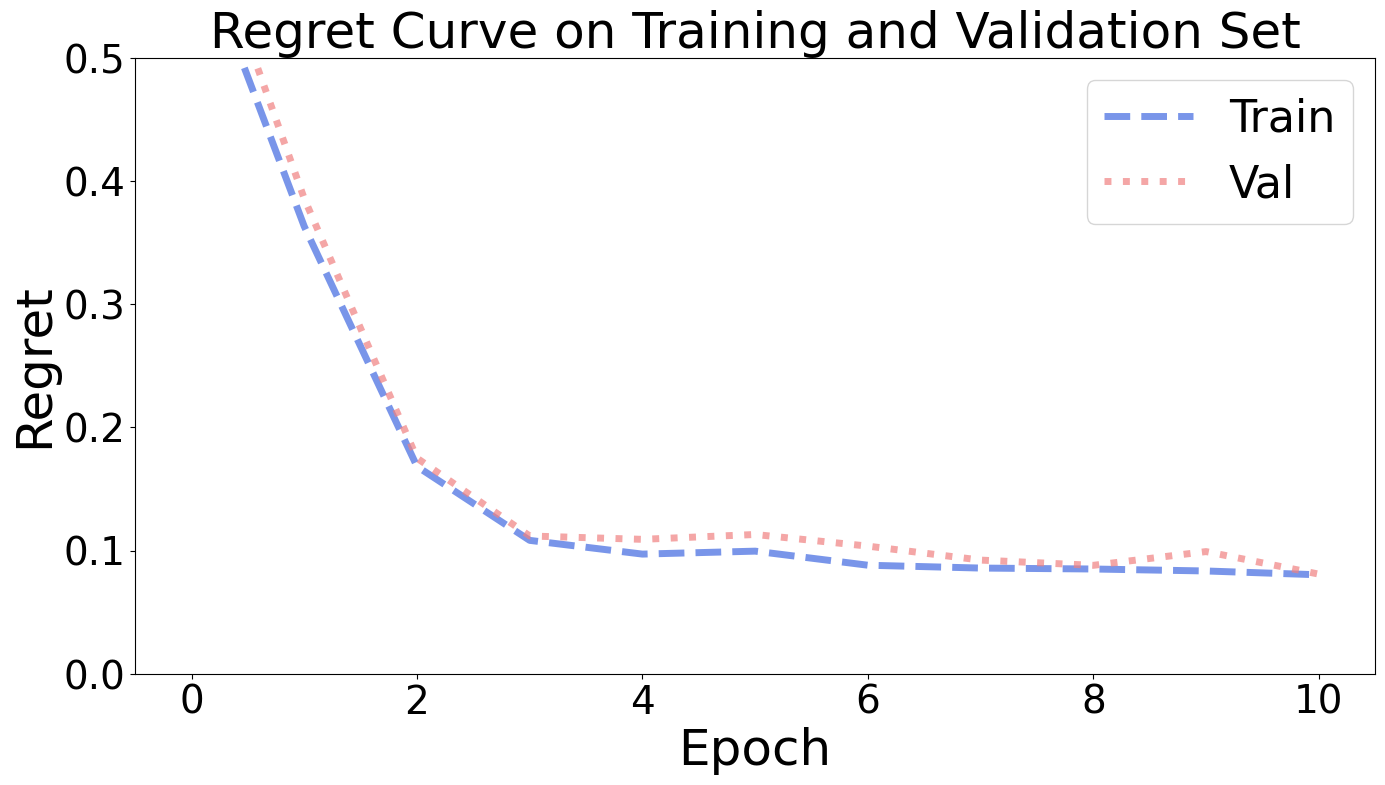

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [34]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  60.5412%, Val Regret:  64.2153%


Epoch    0, Loss:  -0.9997:  10%|█████▌                                                 | 1/10 [00:04<00:27,  3.04s/it]

Epoch   1, Train Regret:   8.9549%, Val Regret:   9.5090%


Epoch    1, Loss:  -0.9997:  20%|███████████                                            | 2/10 [00:07<00:24,  3.01s/it]

Epoch   2, Train Regret:   8.8421%, Val Regret:  10.8573%


Epoch    2, Loss:  -0.9997:  30%|████████████████▌                                      | 3/10 [00:10<00:21,  3.02s/it]

Epoch   3, Train Regret:   8.7834%, Val Regret:  10.6311%


Epoch    3, Loss:  -0.9997:  40%|██████████████████████                                 | 4/10 [00:13<00:20,  3.46s/it]


Epoch   4, Train Regret:   8.6982%, Val Regret:  11.5327%

Early Stop!
Training Elapsed Time: 0.92 Sec

Evaluation:
Test Regret: 9.7249%
Test Elapsed Time: 1.50 Sec


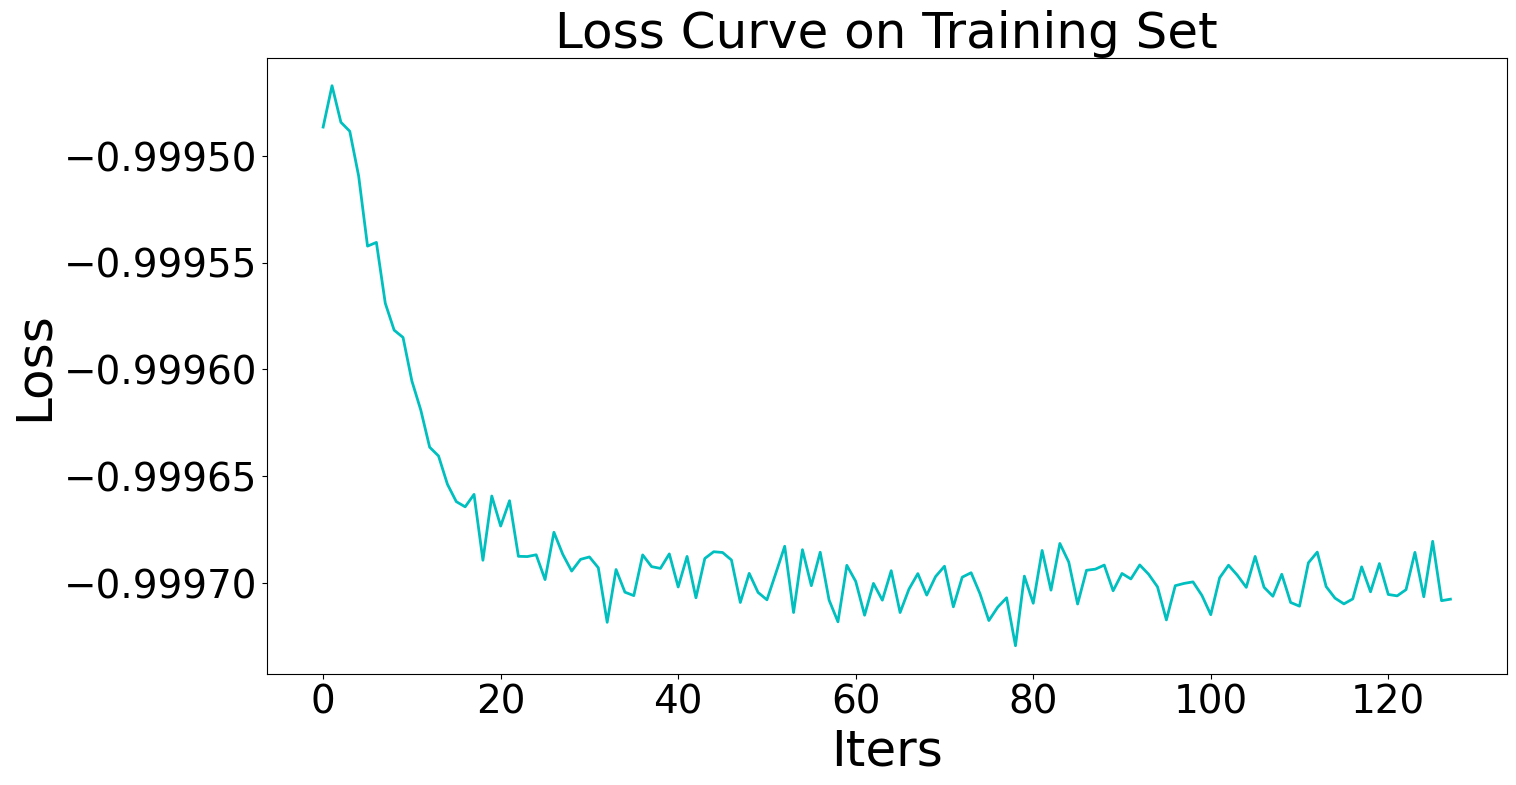

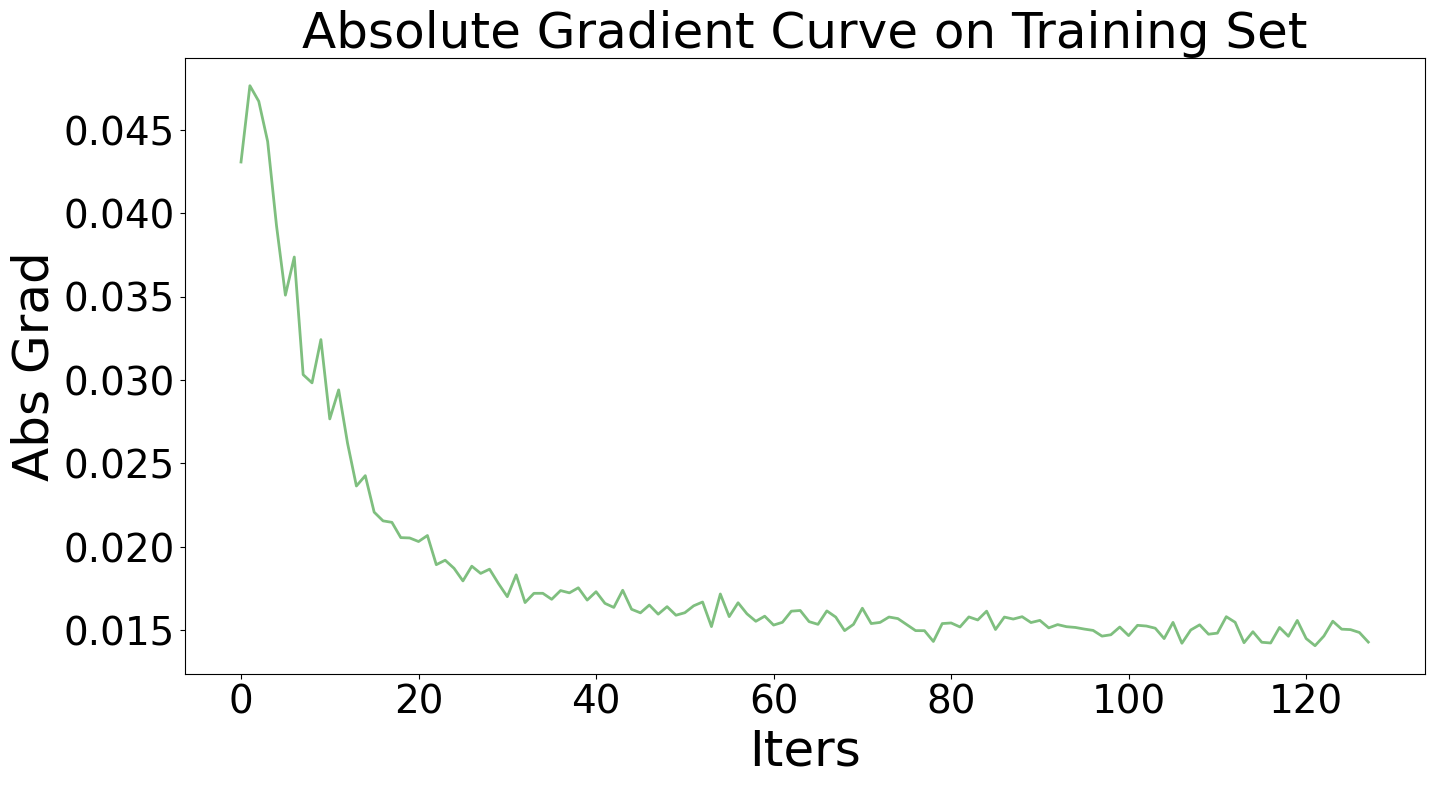

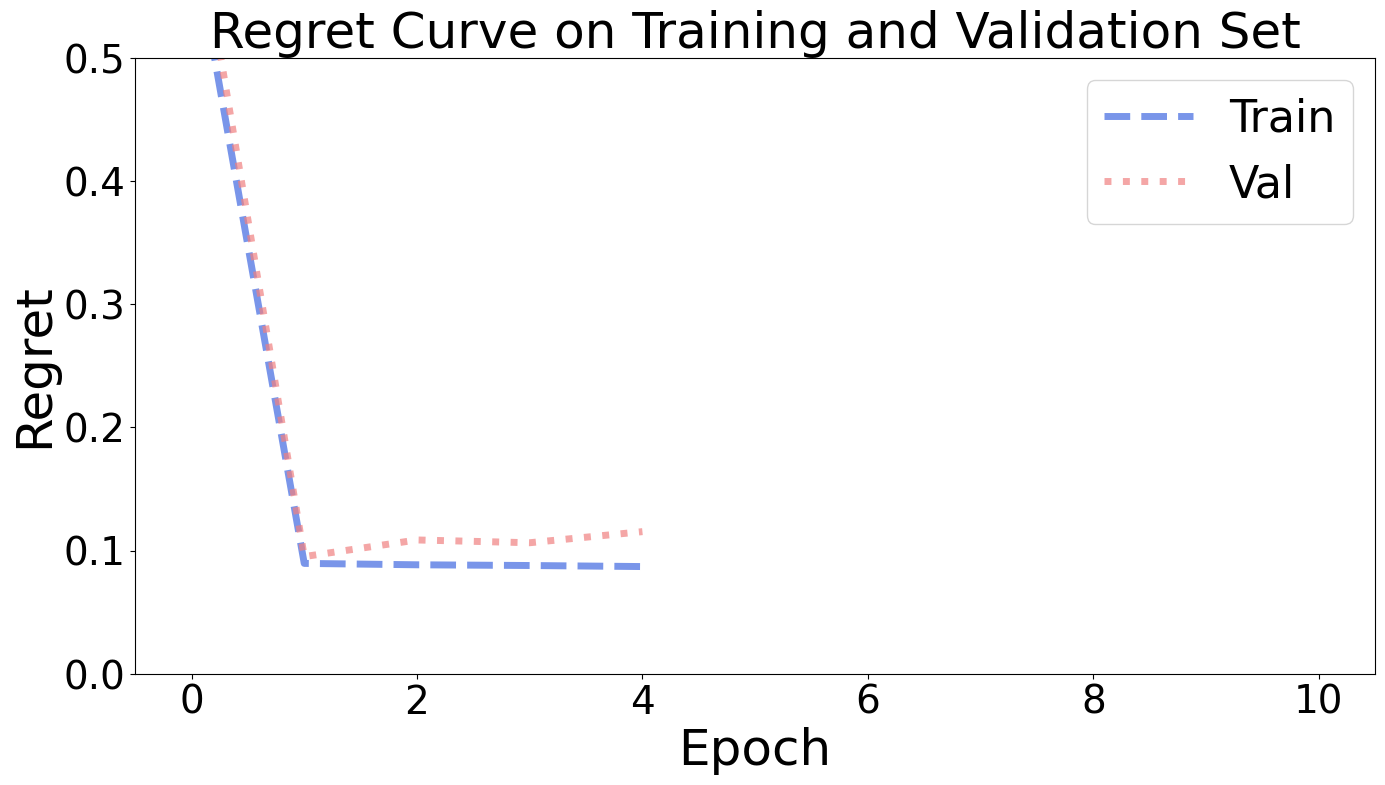

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [38]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  53.4340%, Val Regret:  54.0335%


Epoch    0, Loss:  -0.9997:  10%|█████▌                                                 | 1/10 [00:06<00:40,  4.50s/it]

Epoch   1, Train Regret:   8.3808%, Val Regret:  10.7001%


Epoch    1, Loss:  -0.9998:  20%|███████████                                            | 2/10 [00:10<00:36,  4.56s/it]

Epoch   2, Train Regret:   9.3188%, Val Regret:   9.7662%


Epoch    2, Loss:  -0.9999:  30%|████████████████▌                                      | 3/10 [00:15<00:32,  4.59s/it]

Epoch   3, Train Regret:   8.5765%, Val Regret:  10.1713%


Epoch    3, Loss:  -0.9999:  40%|██████████████████████                                 | 4/10 [00:19<00:27,  4.56s/it]

Epoch   4, Train Regret:   9.3406%, Val Regret:  10.2648%


Epoch    4, Loss:  -0.9998:  50%|███████████████████████████▌                           | 5/10 [00:24<00:24,  4.90s/it]


Epoch   5, Train Regret:   9.1389%, Val Regret:  11.0837%

Early Stop!
Training Elapsed Time: 9.50 Sec

Evaluation:
Test Regret: 10.6369%
Test Elapsed Time: 1.50 Sec


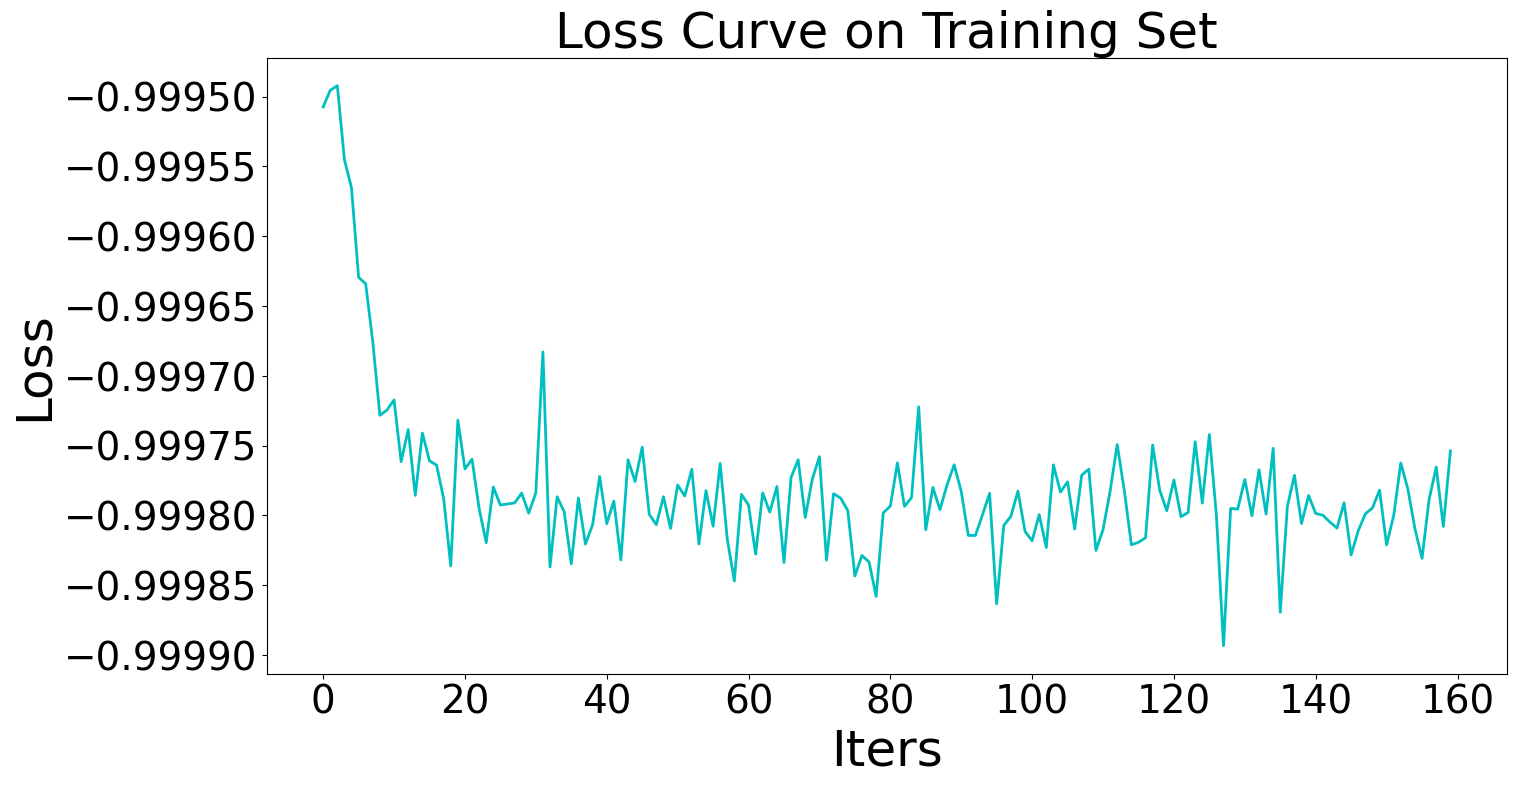

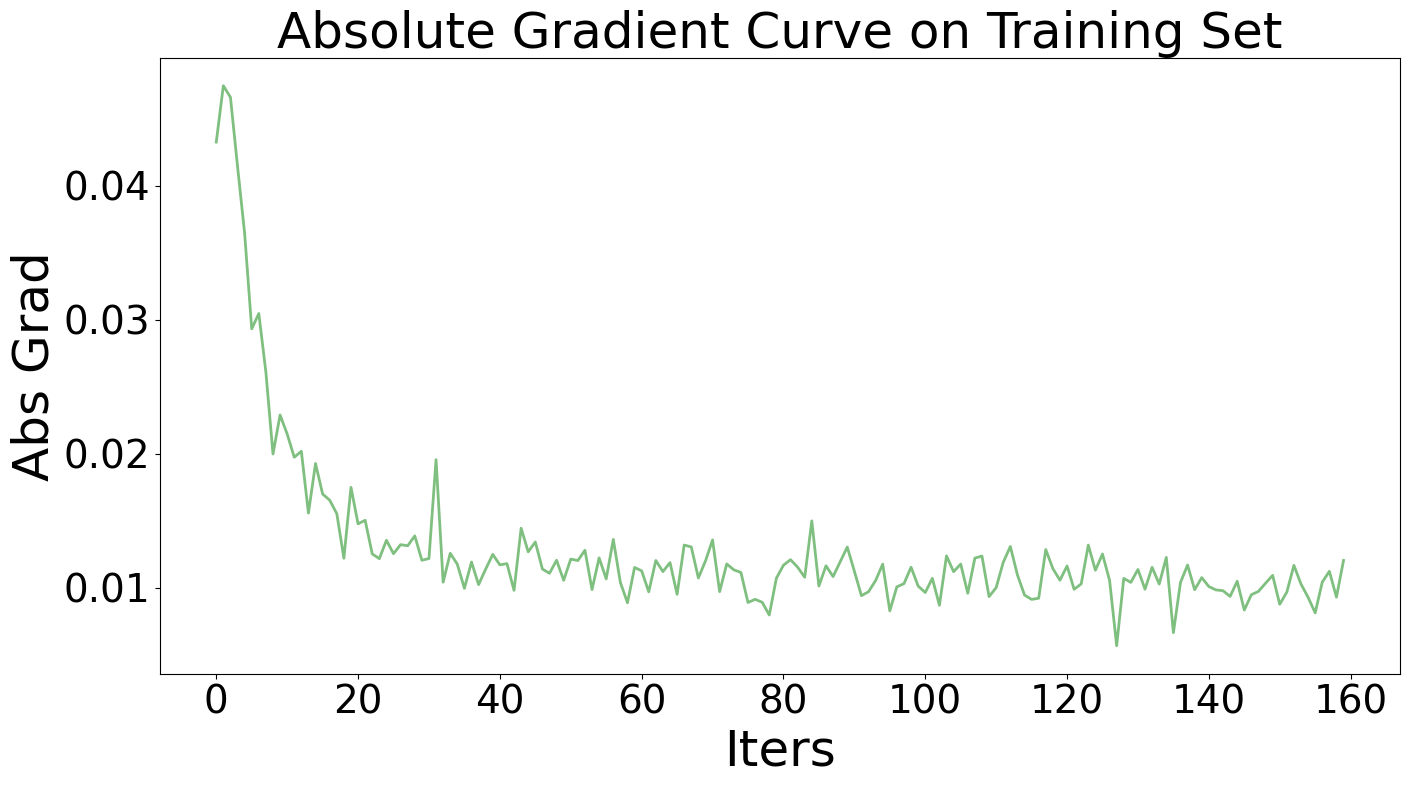

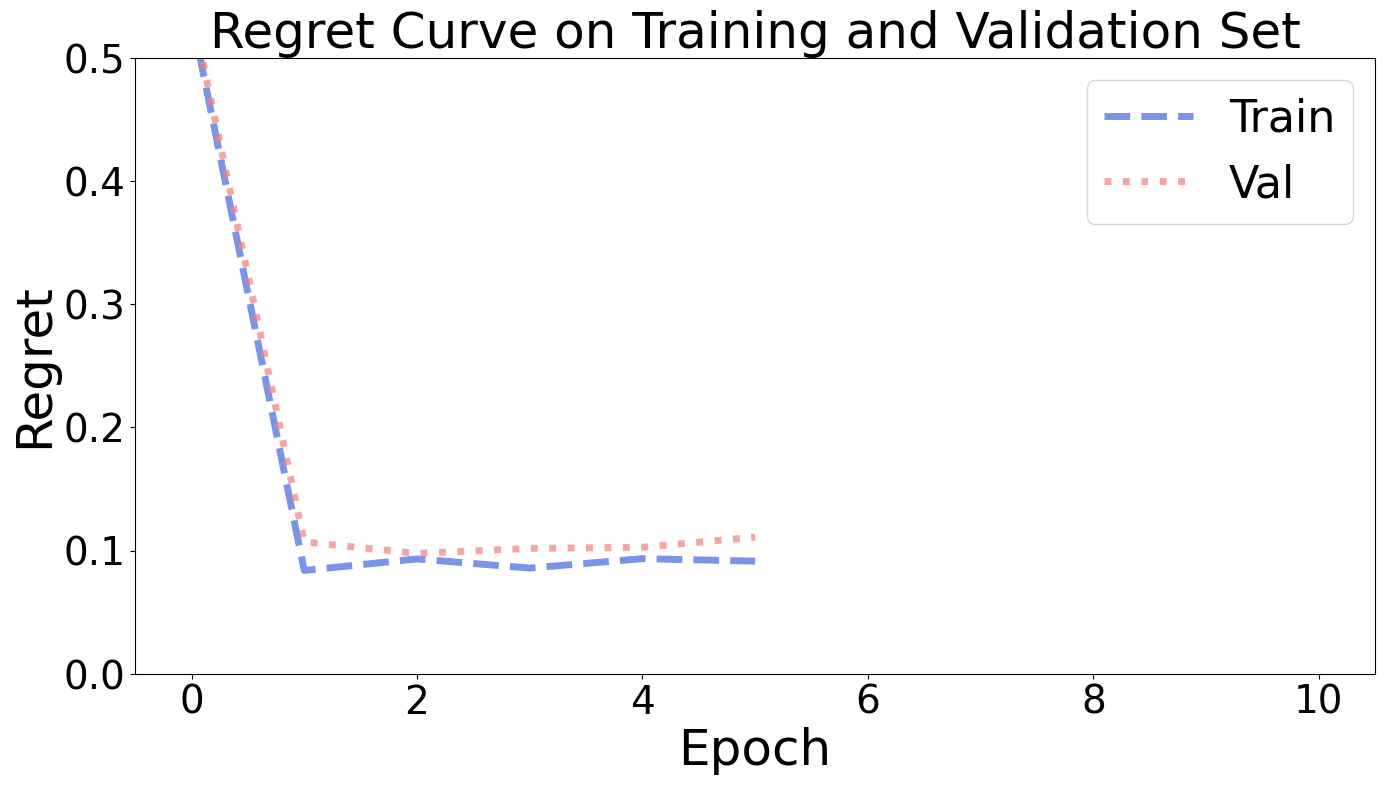

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [42]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  61.3484%, Val Regret:  63.0942%


Epoch    0, Loss:  -0.9998:  10%|█████▌                                                 | 1/10 [00:04<00:24,  2.70s/it]

Epoch   1, Train Regret:   8.9055%, Val Regret:   8.8339%


Epoch    1, Loss:  -0.9998:  20%|███████████                                            | 2/10 [00:07<00:21,  2.73s/it]

Epoch   2, Train Regret:   9.3734%, Val Regret:  10.7874%


Epoch    2, Loss:  -0.9998:  30%|████████████████▌                                      | 3/10 [00:09<00:19,  2.73s/it]

Epoch   3, Train Regret:   9.4204%, Val Regret:  10.2792%


Epoch    3, Loss:  -0.9998:  40%|██████████████████████                                 | 4/10 [00:12<00:18,  3.15s/it]


Epoch   4, Train Regret:   8.9375%, Val Regret:  11.3231%

Early Stop!
Training Elapsed Time: 0.40 Sec

Evaluation:
Test Regret: 9.1026%
Test Elapsed Time: 1.53 Sec


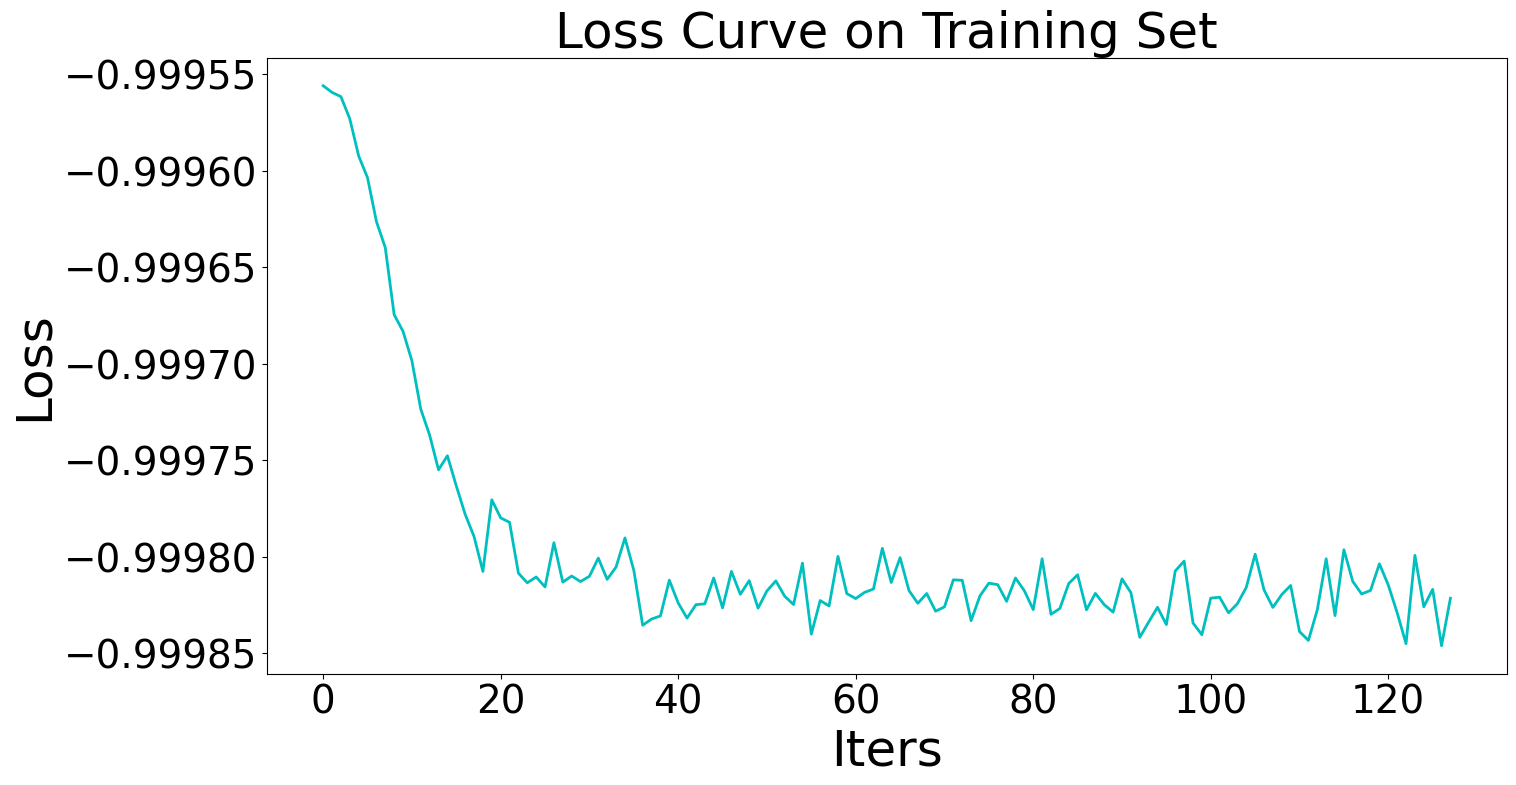

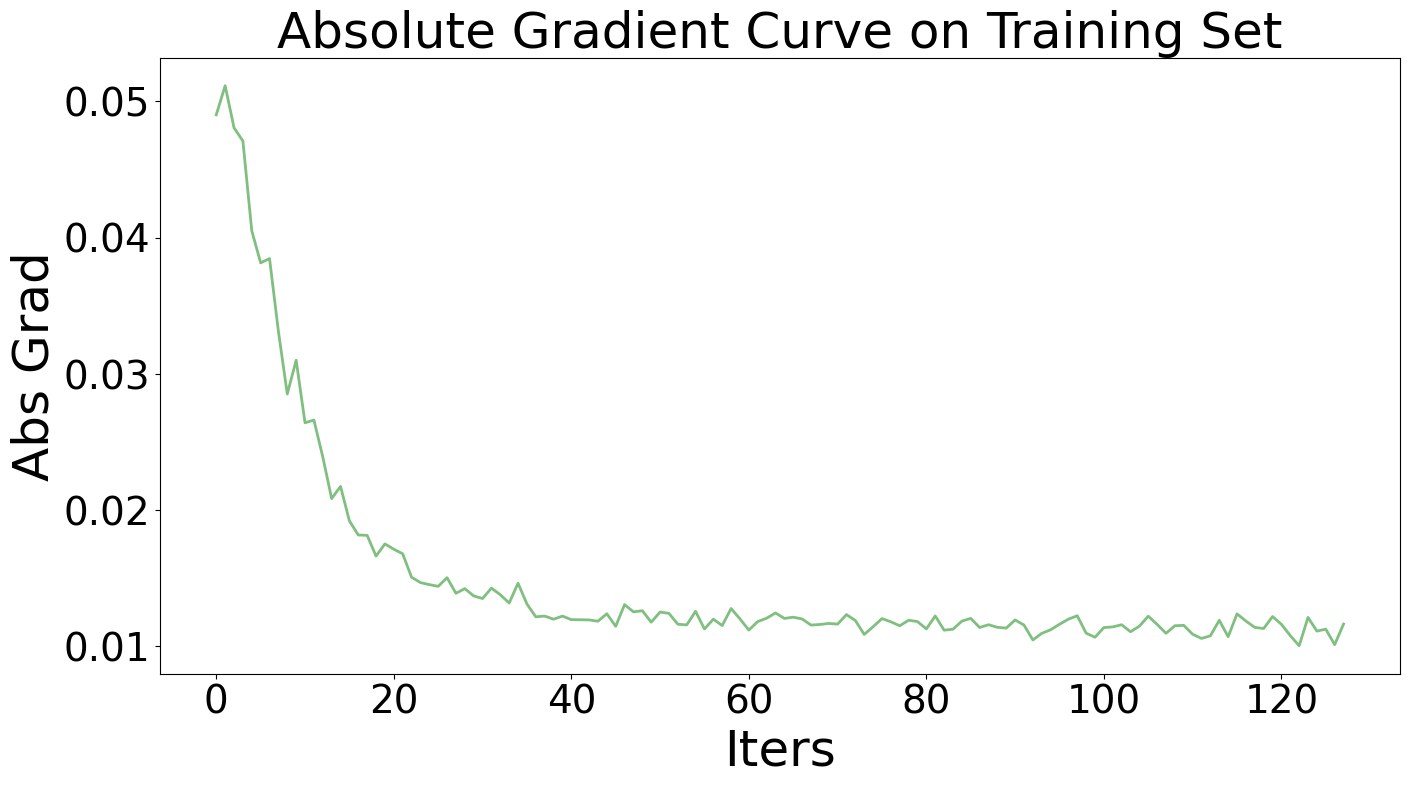

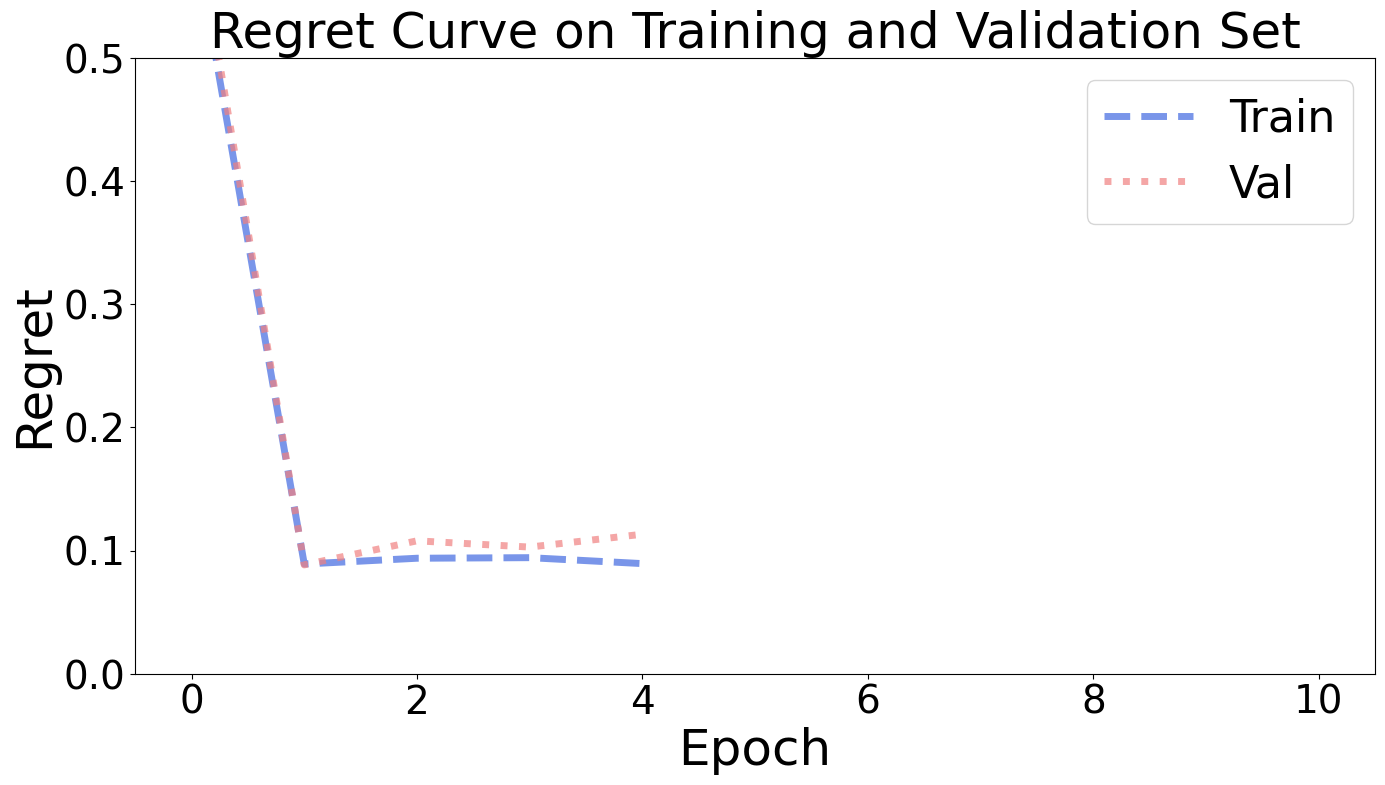

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method with Cone Check 

In [44]:
# init model
reg = LinearRegression()

In [45]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [46]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test, grad_clip=True)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  71.2160%, Val Regret:  73.2458%


Epoch    0, Loss:  -0.9998:  10%|█████▌                                                 | 1/10 [00:06<00:40,  4.48s/it]

Epoch   1, Train Regret:   8.4993%, Val Regret:   8.9125%


Epoch    1, Loss:  -0.9998:  20%|███████████                                            | 2/10 [00:10<00:35,  4.48s/it]

Epoch   2, Train Regret:   8.8192%, Val Regret:   9.5240%


Epoch    2, Loss:  -0.9999:  30%|████████████████▌                                      | 3/10 [00:15<00:31,  4.48s/it]

Epoch   3, Train Regret:   9.9303%, Val Regret:   9.5219%


Epoch    3, Loss:  -0.9999:  40%|██████████████████████                                 | 4/10 [00:19<00:29,  4.90s/it]


Epoch   4, Train Regret:   9.6286%, Val Regret:  10.5414%

Early Stop!
Training Elapsed Time: 7.23 Sec

Evaluation:
Test Regret: 9.3110%
Test Elapsed Time: 1.54 Sec


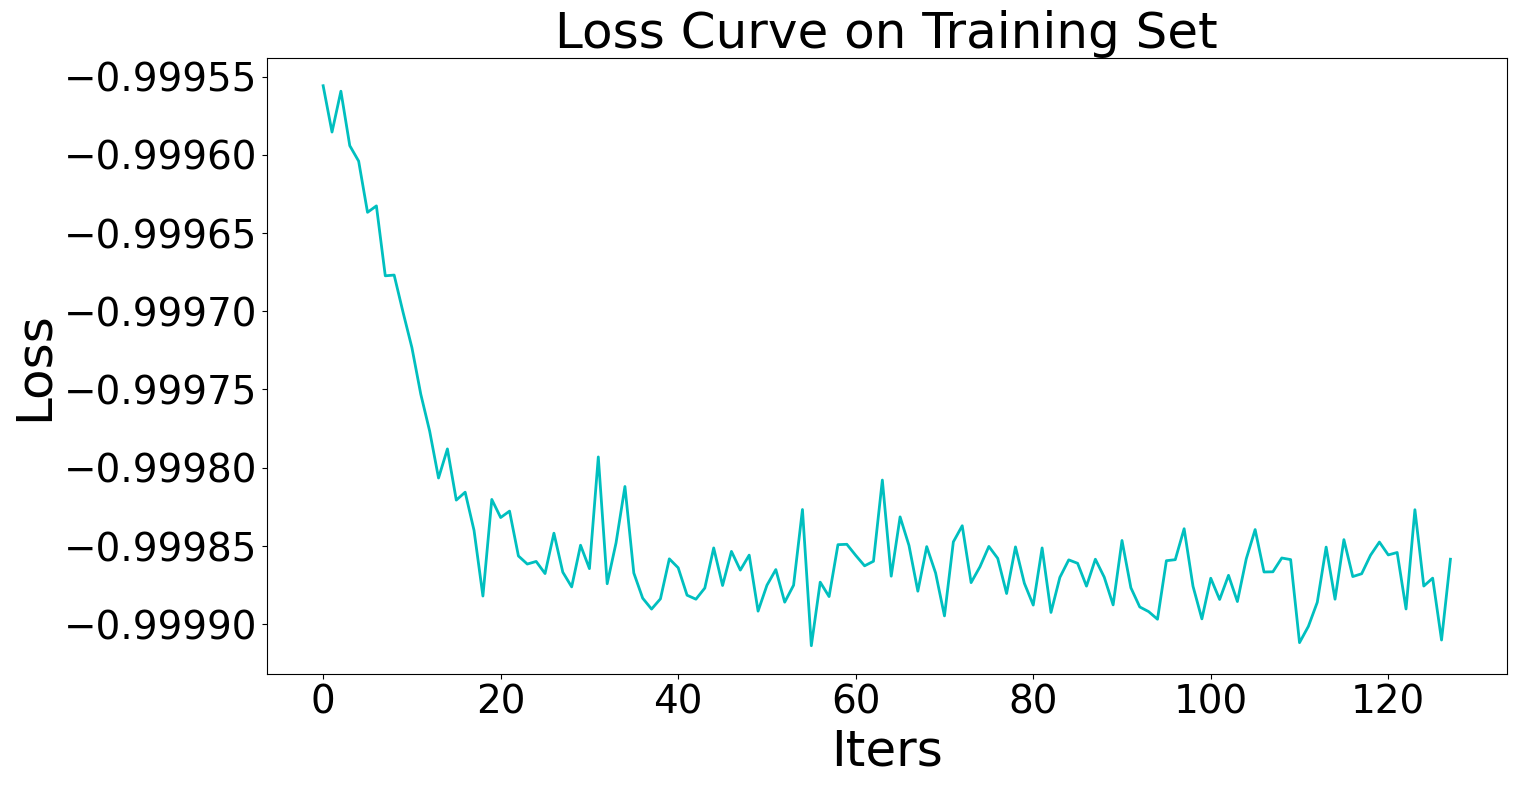

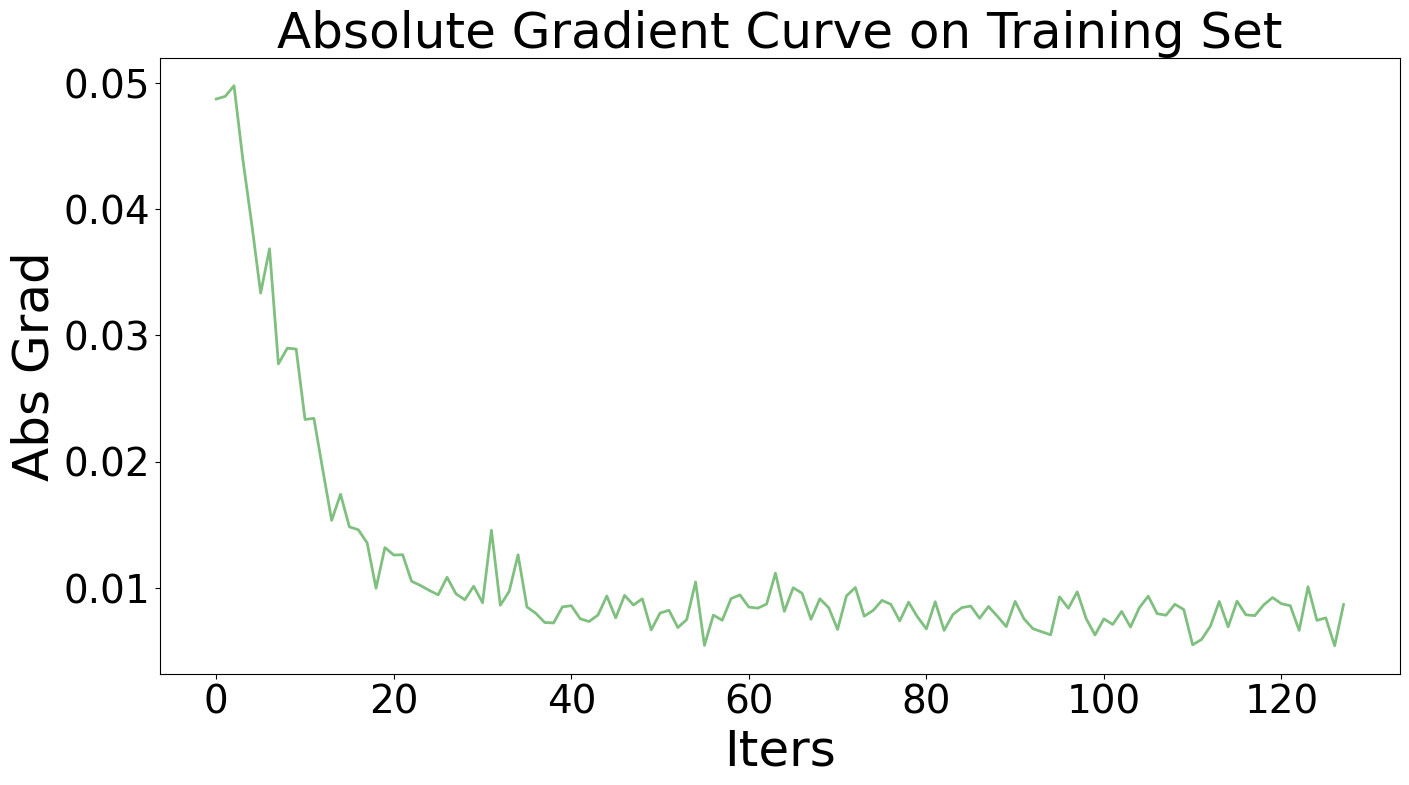

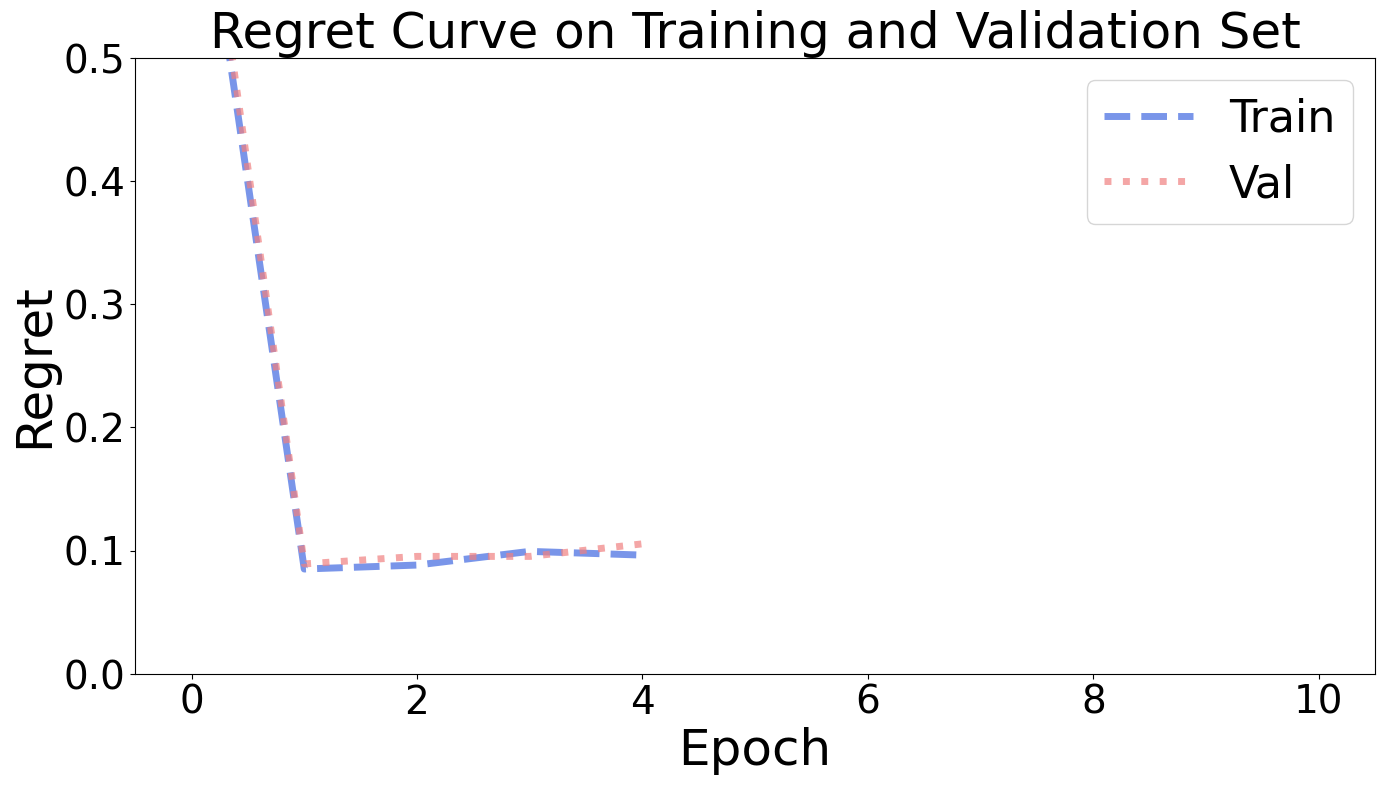

In [47]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [48]:
# init model
reg = LinearRegression()

In [49]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [50]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  71.2160%, Val Regret:  73.2458%


Epoch    0, Loss:  10.7500:  10%|█████▌                                                 | 1/10 [00:06<00:39,  4.37s/it]

Epoch   1, Train Regret:  15.3106%, Val Regret:  15.8925%


Epoch    1, Loss:   8.0000:  20%|███████████                                            | 2/10 [00:10<00:34,  4.37s/it]

Epoch   2, Train Regret:   8.5674%, Val Regret:   7.5215%


Epoch    2, Loss:   6.2500:  30%|████████████████▌                                      | 3/10 [00:15<00:31,  4.44s/it]

Epoch   3, Train Regret:   7.9238%, Val Regret:   7.2864%


Epoch    3, Loss:   9.0000:  40%|██████████████████████                                 | 4/10 [00:19<00:26,  4.43s/it]

Epoch   4, Train Regret:   7.1219%, Val Regret:   9.4633%


Epoch    4, Loss:   9.5000:  50%|███████████████████████████▌                           | 5/10 [00:23<00:22,  4.41s/it]

Epoch   5, Train Regret:   7.0127%, Val Regret:   7.3325%


Epoch    5, Loss:   7.5000:  60%|█████████████████████████████████                      | 6/10 [00:28<00:18,  4.69s/it]


Epoch   6, Train Regret:   7.0154%, Val Regret:   7.5220%

Early Stop!
Training Elapsed Time: 10.18 Sec

Evaluation:
Test Regret: 7.3757%
Test Elapsed Time: 1.56 Sec


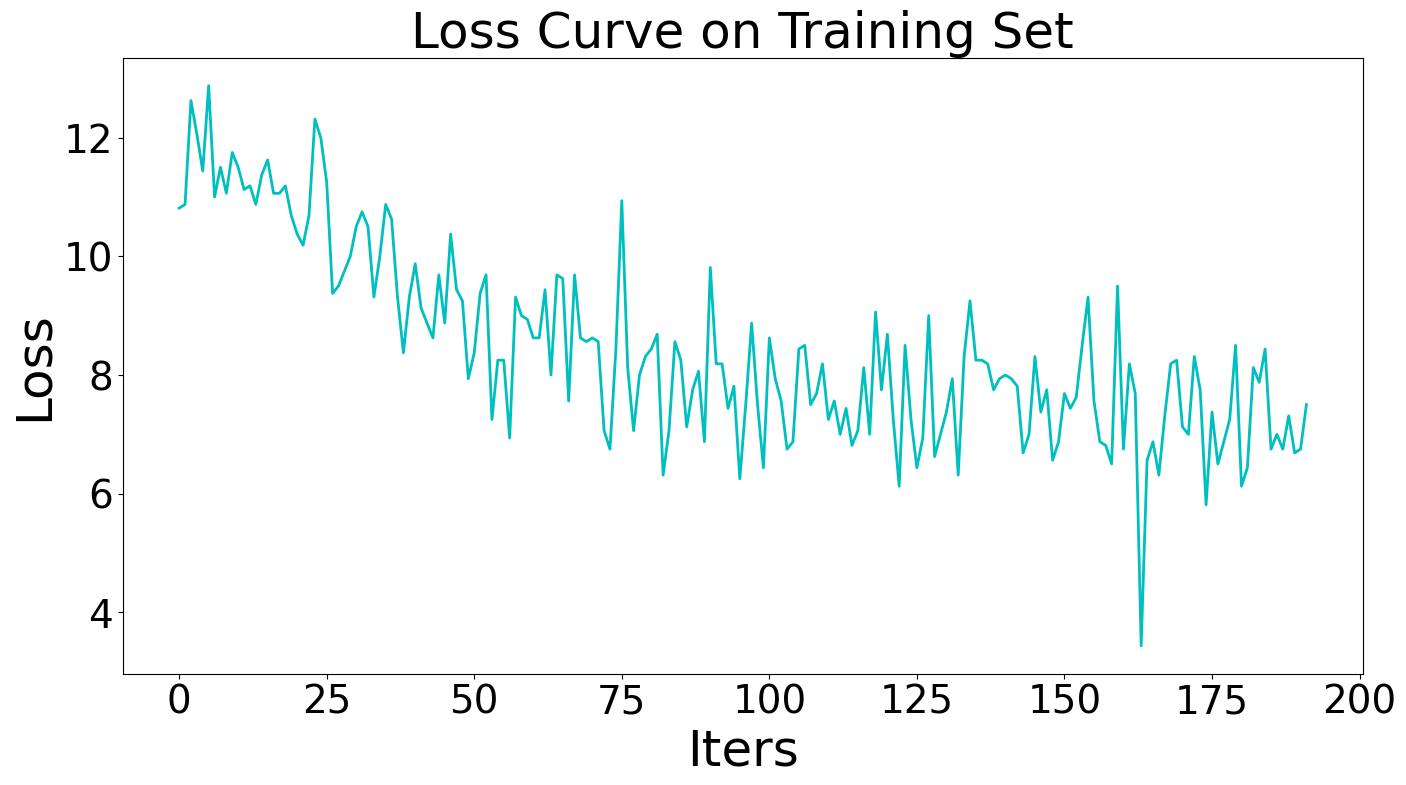

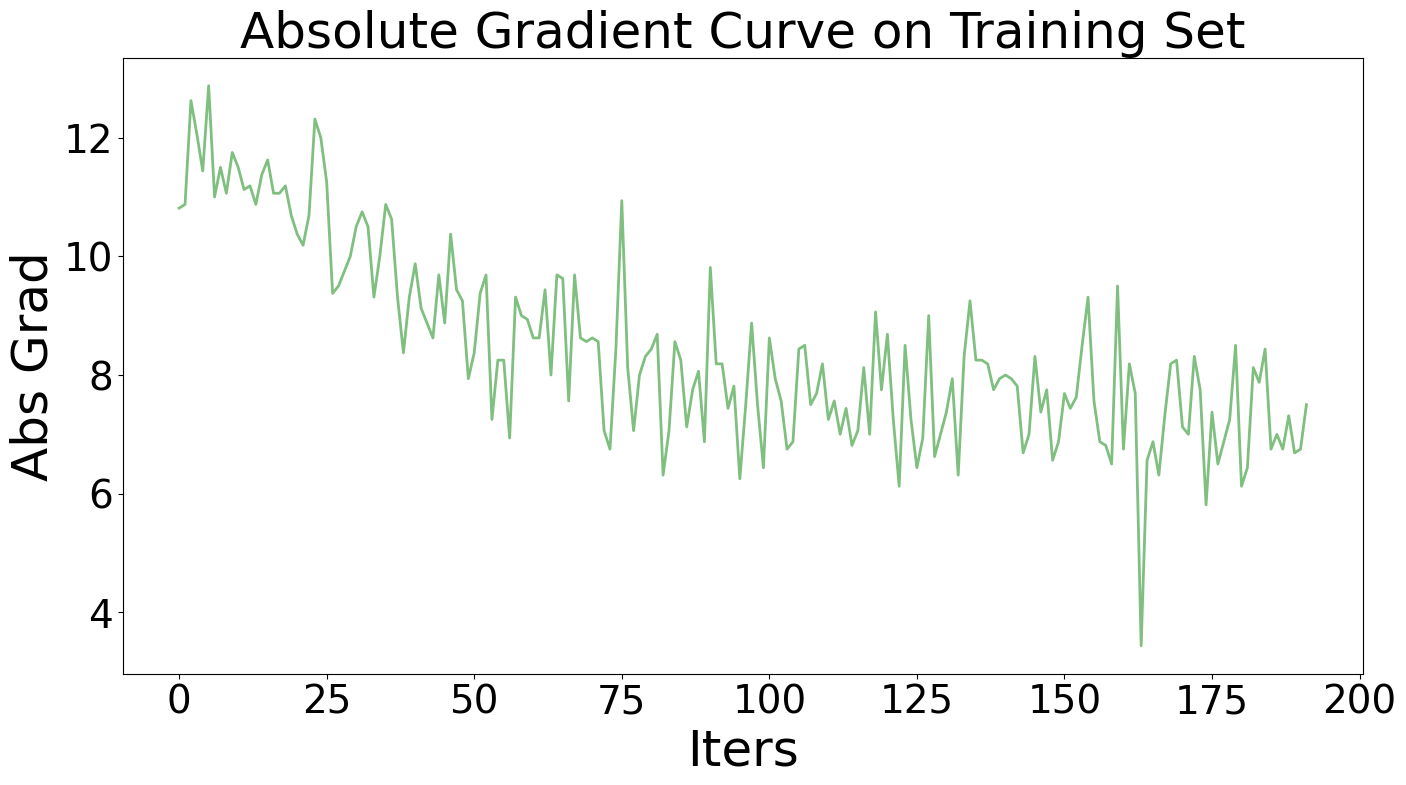

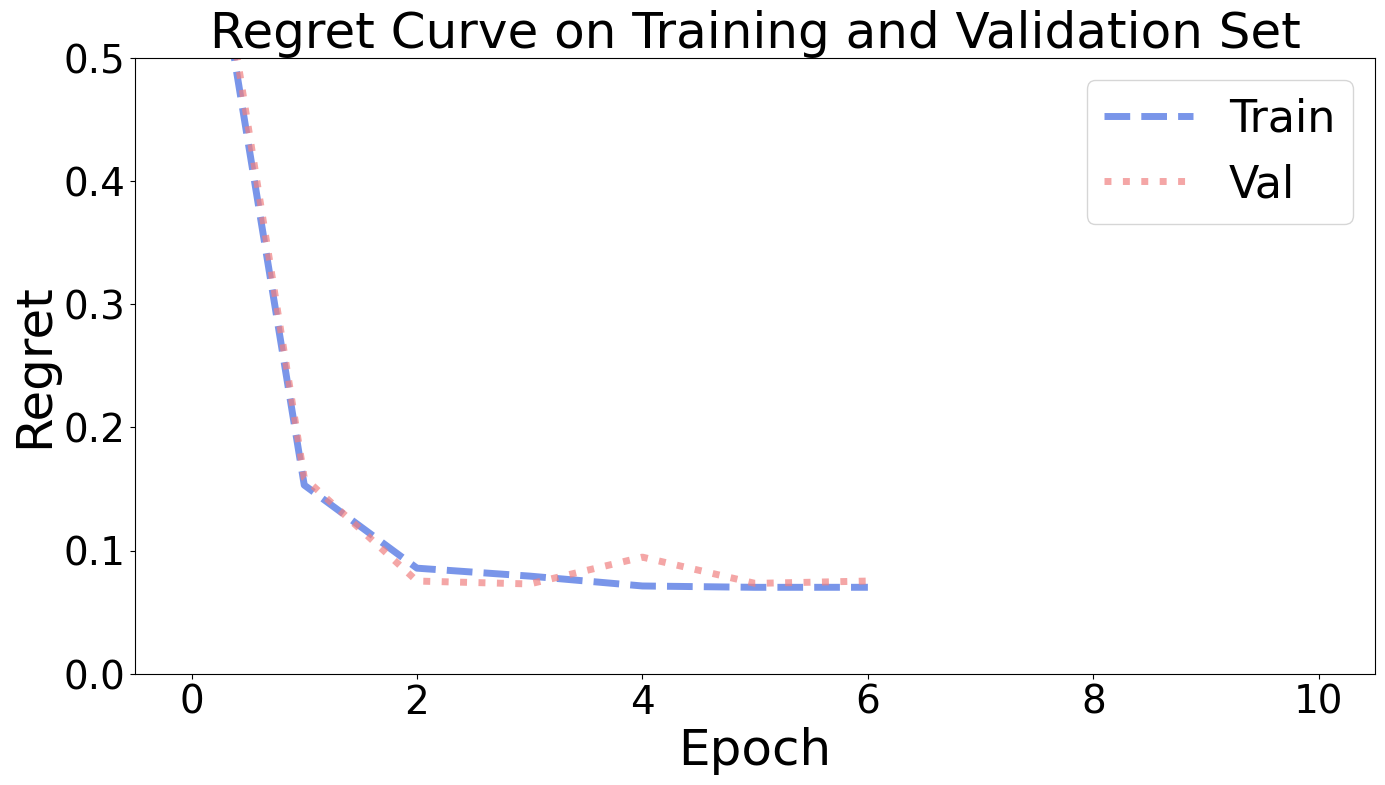

In [51]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [52]:
# init model
reg = LinearRegression()

In [53]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [54]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/10 [00:01<?, ?it/s]

Epoch   0, Train Regret:  56.6962%, Val Regret:  51.7348%


Epoch    0, Loss:  -2.6333:  10%|█████▌                                                 | 1/10 [00:04<00:26,  2.90s/it]

Epoch   1, Train Regret:  18.6795%, Val Regret:  19.2104%


Epoch    1, Loss:  -7.0799:  20%|███████████                                            | 2/10 [00:07<00:23,  2.93s/it]

Epoch   2, Train Regret:  13.1888%, Val Regret:  12.0702%


Epoch    2, Loss: -11.0950:  30%|████████████████▌                                      | 3/10 [00:10<00:20,  2.97s/it]

Epoch   3, Train Regret:  11.8177%, Val Regret:  12.3084%


Epoch    3, Loss: -11.5656:  40%|██████████████████████                                 | 4/10 [00:13<00:18,  3.02s/it]

Epoch   4, Train Regret:  11.5927%, Val Regret:  11.9728%


Epoch    4, Loss: -10.4828:  50%|███████████████████████████▌                           | 5/10 [00:17<00:15,  3.08s/it]

Epoch   5, Train Regret:  11.4764%, Val Regret:  11.1258%


Epoch    5, Loss: -27.1116:  60%|█████████████████████████████████                      | 6/10 [00:20<00:12,  3.09s/it]

Epoch   6, Train Regret:  11.2114%, Val Regret:  10.7127%


Epoch    6, Loss: -27.1681:  70%|██████████████████████████████████████▌                | 7/10 [00:23<00:09,  3.16s/it]

Epoch   7, Train Regret:  10.8684%, Val Regret:  10.6472%


Epoch    7, Loss: -19.5132:  80%|████████████████████████████████████████████           | 8/10 [00:26<00:06,  3.19s/it]

Epoch   8, Train Regret:  10.6632%, Val Regret:  10.3441%


Epoch    8, Loss: -46.0244:  90%|█████████████████████████████████████████████████▌     | 9/10 [00:29<00:03,  3.10s/it]

Epoch   9, Train Regret:  10.6357%, Val Regret:  10.9719%


Epoch    9, Loss: -38.1178: 100%|██████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.07s/it]


Epoch   9, Train Regret:  10.5990%, Val Regret:  10.9494%
Training Elapsed Time: 2.23 Sec

Evaluation:
Test Regret: 10.8272%
Test Elapsed Time: 1.58 Sec


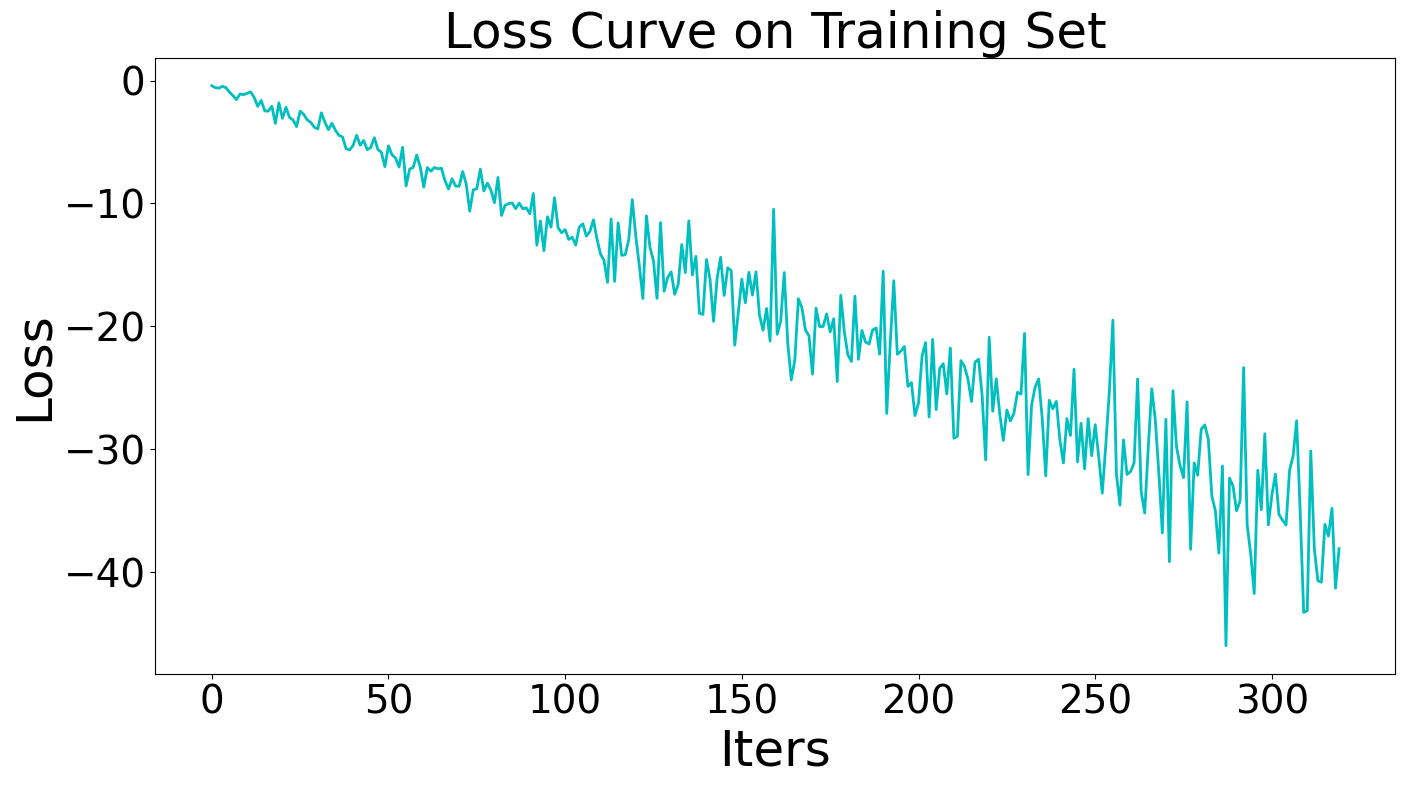

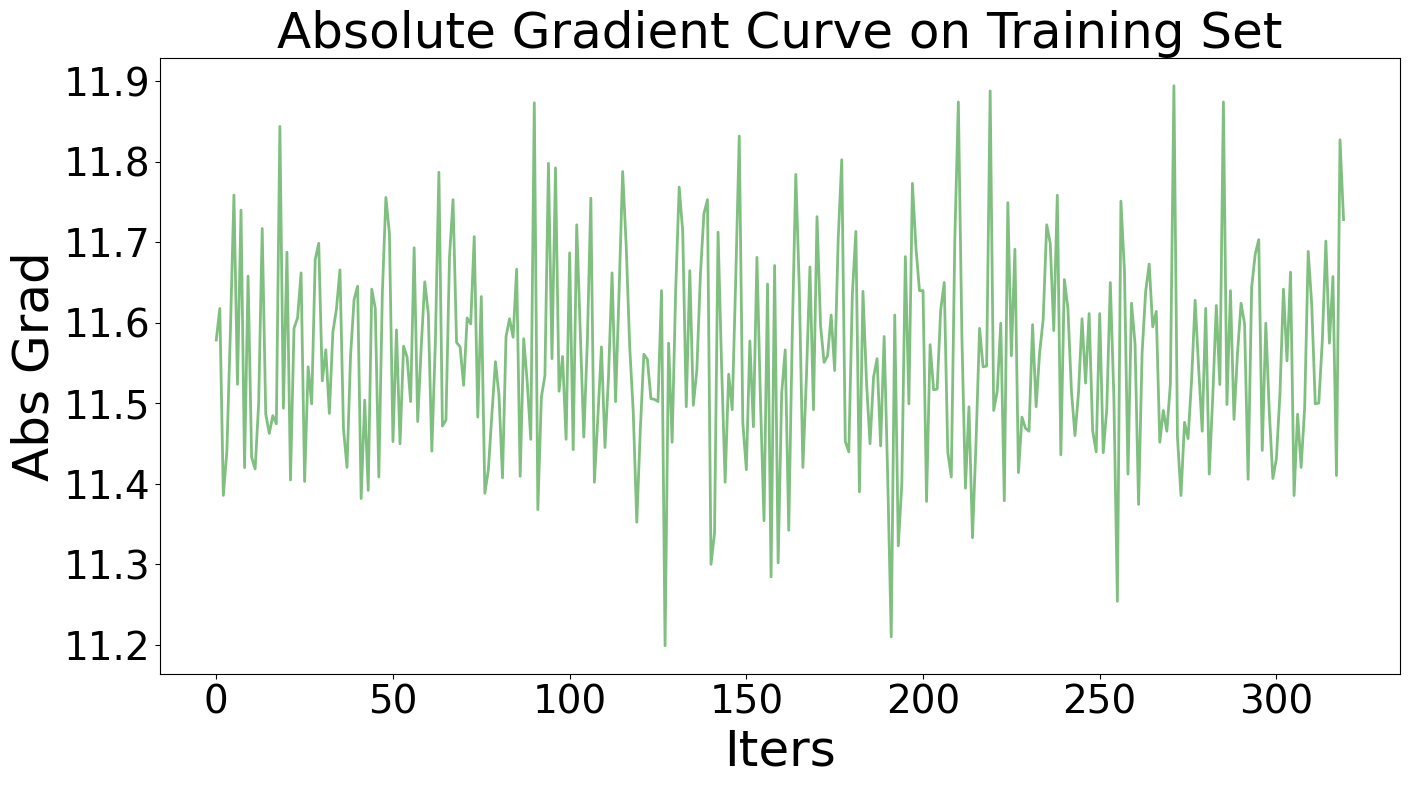

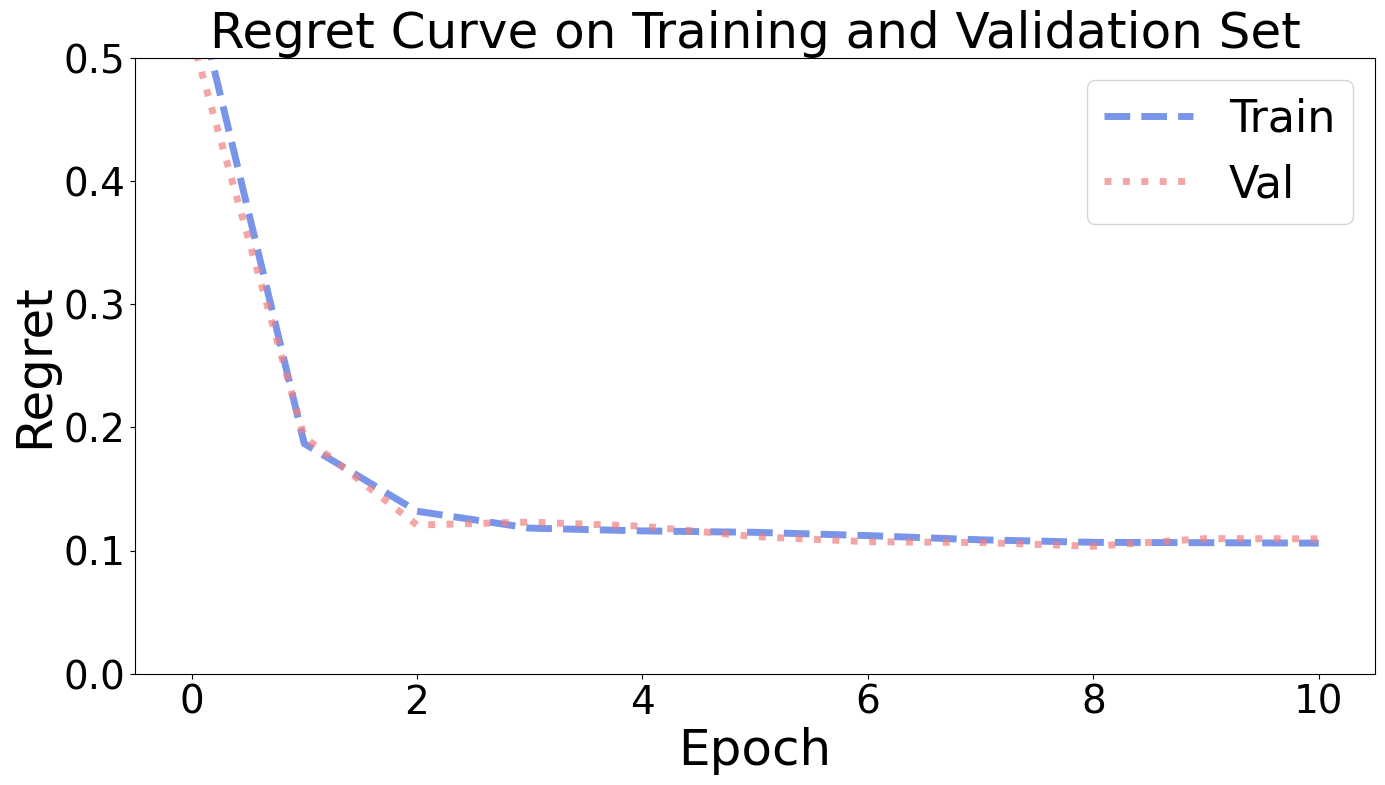

In [55]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)